# Bitcoin From Scratch


A while ago I decided I really wanted to understand how Bitcoin works. So, being a firm believer in the notion that the best way to understand something is by doing it, I decided to code it from scratch. 

The goal of this post is to provide a solid understanding of the core functionality of Bitcoin. We'll take a bottom-up approach here--starting with some basic math and working our way up to creating (and broadcasting) a Bitcoin transaction. After that, we'll talk a bit about blocks and the blockchain. 

If you're interested, here is the github library I wrote associated with all of this: https://github.com/trevormcguire/pybitcoin

Hope you enjoy!

## First Things First

Before we get into Bitcoin, it is important to understand a few things:

### Finite Fields

A finite field is a set that contains a finite amount of numbers. We can denote this with Fp where "p" (called prime) is the size of the set. For our purposes, what this means is that in a finite field, any number greater than "p" doesn't exist.

    Fp= {0, 1, 2, … p-1}


For Reference: https://en.wikipedia.org/wiki/Finite_field

### Modular Arithmetic

In finite field math, any operation must return a number that is also in the set (this property is called closed). If the result of a math operation is larger than the prime (p), the result needs to "wrap around" back to the first element within the field. A good way of visualizing this is to picture a clock. Once the minute-hand passes 11:59, we start back at the beginning (12:00).

Because of this, we'll need to redefine math a bit. To do this we'll use the modulo (mod) operator, which returns the remainder after division. In python, the mod operator is %.

For the most part, modular arithmetic is the same as normal arithmetic, with an extra mod operator step. For example, take a look at finite field addition:

    Let p = 4, x = 3, y = 2 

    (x + y) % p
    (3 + 2) % 4
    5 % 4 = 1

Similarly, take a look at subtraction:

    (3–2) % 4 = 1



In [1]:
p = 4
x = 3
y = 2

print(f"Fp = {set(range(p))}")
print(f"Addition: {(x + y) % p}")
print(f"Subtraction: {(x - y) % p}")
print(f"Multiplication: {(x * y) % p}")

Fp = {0, 1, 2, 3}
Addition: 1
Subtraction: 1
Multiplication: 2


As you can see, modular arithmetic is pretty straightforward. However, there is one exception: division. 

To handle division, we will need to utilize something called Fermat's Little Theorem.


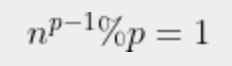

In short, this theorem states that for any prime (p), a number raised to the power of p-1 is 1.

Practically, what this states is that in a finite field with p = 10, any number raised to 9 is equal to 1.


Okay, so why do we care about all this? Well, since division is the inverse of multiplication ( a/b = a * 1/b = a * b^-1 ), we can turn this into a multiplication problem and utilize Fermat's Little Theorem. By doing this, we get the below:
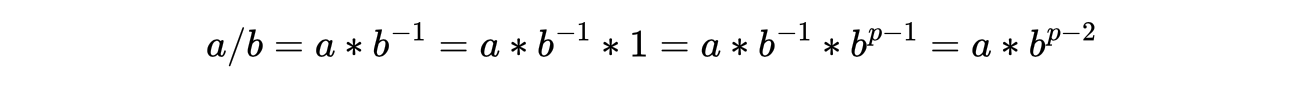

So we know we can rewrite a/b as a * (b^-1). 

The beautiful part of Fermat's Little Theorem (at least for our purposes) is the right side of the equation (the "1"). 

Since we know b^-1 is equal to b^-1 * 1, we can replace the 1 with the left side of the theorem. By doing this, we ultimately get a/b = a * b^(p-2).

Let's write function to handle modular division for us:


In [2]:
from __future__ import annotations
from random import randint
from io import BytesIO
from typing import *
from dataclasses import dataclass
import hashlib
import hmac

def modulardiv(a: int, b: int, p: int) -> int:
    """
    ----------
    Modular Multiplicative Inverse
    a and b are two numbers within Fp, where p is the size of the finite field
    Note: Pytohn's pow() function takes the number, the exponent, and a modulo
    ----------
    """
    return (a * pow(b, p-2, p)) % p

modulardiv(4, 50, 33)

2

### Elliptic Curves

Elliptic Curves have the form y² = x³ + ax + b

Because y² is on the left side of the equation, elliptic curves are symmetric over the x axis.


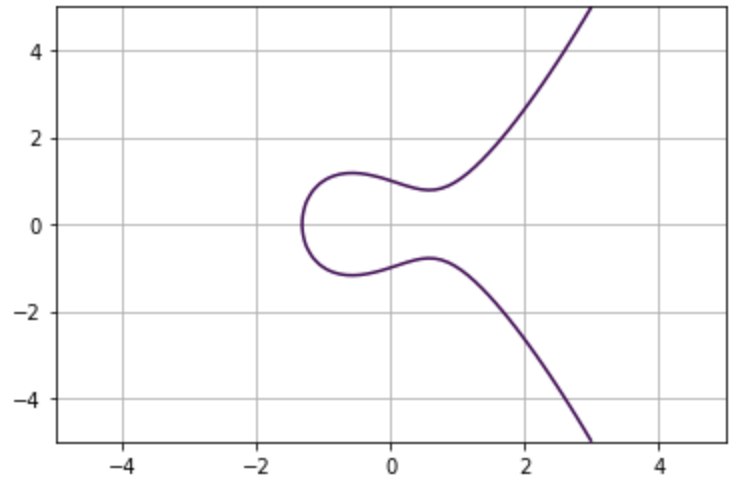

In Bitcoin, we are interested in specific points along an elliptic curve.

The parameters of the elliptic curve used in Bitcoin are specified in secp256k1 (https://en.bitcoin.it/wiki/Secp256k1). These parameters are written in the code below.

If you aren't familiar with the hexadecimal (base-16) numbering system, I got you--read this: https://www.sciencedirect.com/topics/engineering/hexadecimal

Because "a" is 0 and "b" is 7, we can shorten Bitcoin's elliptic curve equation to y² = x³ + 7.

In [3]:
#secp256k1 constants
P = 0xFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFEFFFFFC2F #prime
A = 0x0000000000000000000000000000000000000000000000000000000000000000 # a = 0
B = 0x0000000000000000000000000000000000000000000000000000000000000007 # b = 7
Gx = 0x79BE667EF9DCBBAC55A06295CE870B07029BFCDB2DCE28D959F2815B16F81798 #x coord
Gy = 0x483ada7726a3c4655da4fbfc0e1108a8fd17b448a68554199c47d08ffb10d4b8 #y coord
N = 0xFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFEBAAEDCE6AF48A03BBFD25E8CD0364141 #order of G

### Elliptic Curve Cryptography (ECC)

So here's why all this matters: Bitcoin uses an elliptic curve that exists within a finite field. More specifically, Bitcoin exists in a finite field with prime "P", and on a curve y^2 = x^3 + ax + b, where "a" = 0 and "b" = 7. Note how "P", "a", and "b" are all constants in secp256k1 (that we just defined).


In Bitcoin, elliptic curves are used for key generation and digital signatures. For signatures, something called the ECDSA (Elliptic Curve Digital Signature Algorithm) is used, which we will dig into shortly.


## Building Blocks

Since Bitcoin utilizes an elliptic curve, we will want to create an object representing this this. Moreover, since we are interested in specific points along this curve, we should also create a class to represent the (x, y) coordinates of a point along it.

In Bitcoin, we'll also need to add and multiply points together, so we will also define those operators.

Point addition can be thought of as drawing a line between two points, and then extending it until the line intersects the curve once again. This result is finally flipped over the x-axis to obtain the sum.

The process for Point Addition is the below:

            Case1 -> self.x == p.x
                slope = (3*x1^2 + a) / 2y1
                x3 = s^2 - 2x1
                y3 = s(x1 - x3) - y1
                
            Case2 -> self.x != p.x
                slope = (y2 - y1) / (x2 - x1)
                x3 = s^2 - x1 - x2
                y3 = s(x1 - x3) - y1
                
            Case3 -> self == INF #identity fn
                return p
                
            Case4 -> p == INF #identity fn
                return self
                
            Case5 -> self.x == p.x and self.y != p.y #additive inverse -a + a = 0
                return INF
                
            Case6 -> self.x == p.x and self.y == 0 #line is tangent
                return INF
                
                
Point Multiplication is just multiple iterations of Point Addition (3G = G + G + G). We implement the Double and Add algorithm below for efficiency (since we will be working with huge integers).

In [4]:
class Curve(object):
    """
    Object Representing an Elliptic Curve of the form y^2 = x^3 + ax + b 
    within a Finite Field with prime (p)
    """
    def __init__(self, p, a, b):
        self.p = p
        self.a = a
        self.b = b
    
    def __repr__(self):
        return f"EllipticCurve(a={self.a}, b={self.b}) in Field({self.p})"

@dataclass
class Point:
    """
    Object Representing a Point (x, y) along a curve
    """
    curve: Curve
    x: int
    y: int

    def __add__(self, other: Point) -> Point:
        if self.x is None:
            return other
        if other.x is None:
            return self
        if self.x == other.x and self.y != other.y:
            return self.__class__(None, None, None) #INF
        
        if self.x == other.x: 
            m = modulardiv((3 * self.x**2 + self.curve.a), 
                           (2*self.y), 
                           P)
        else:
            m = modulardiv((self.y - other.y), 
                           (self.x - other.x), 
                           P)
        rx = (m**2 - self.x - other.x) % self.curve.p
        ry = (-(m*(rx - self.x) + self.y)) % self.curve.p
        return Point(self.curve, rx, ry)
    
    def __rmul__(self, n: int) -> Point:
        """
        Point Multiplication - Double And Add Algorithm
        https://en.wikipedia.org/wiki/Elliptic_curve_point_multiplication
        """
        curr = self
        res = INF #point at infinity -- which you can think of as the point at which the field wraps back around
        while n:
            if n & 1:
                res += curr
            curr += curr
            n >>= 1 #right bitshift
        return res

#E represents the elliptic curve used in bitcoin 
E = Curve(p=P, a=A, b=B)

G = Point(curve=E, x=Gx, y=Gy)

INF = Point(None, None, None)

print(G == 1*G)
print(G + G == 2*G)
print(G + G + G == 3*G)

True
True
True


Lets further dissect the above.

Using the parameters in secp256k1, we define E, which is the elliptic curve on which Bitcoin operates.

We then define something called the Generator Point (G). This is the first point after infinity (INF) on Bitcoin's curve. Infinity can be thought of as the point in which the finite field wraps around back to the beginning. 

If we begin with INF and add G, we get G. If we add G to G, we get 2G. Add another, and we get 3G, and so on. 

If you repeat this process N times (N being the order of G, and a also parameter specified in secp256k1), we again reach INF. So N represents how many points there are along Bitcoin's elliptic curve. As you will see, this concept is important for both private and public key generation (note that in Bitcoin, public keys are just points along its curve). 



## Hash Functions

Before we get into coding up the Bitcoin protocol, we need to briefly touch on hash functions. If you have heard of bitcoin, I'm sure you've also heard of the word "hash"--and rightly so, as hash functions are used everywhere in Bitcoin.

There are many hash functions out there, but in Bitcoin these are the ones you need to know: hash160 and hash256. These are both "double hash functions", because they both perform two rounds of hashing. 

Both of these functions utilize the sha256 hashing algorithm. In fact, hash256 is just two rounds of sha256. Hash160, however, is sha256 followed by another called ripemd160.

What these functions are actually doing is mixing up bits in a way such that it is next to impossible to unscramble them. This is possible because sha256 outputs values in a uniform distribution--meaning, the values are essentially random. This is an important feature of sha256. In fact, the probability of sha256 producing the same hash twice is 10^-60, according to https://www.avira.com/en/blog/md5-the-broken-algorithm. Add in the fact that Bitcoin uses two rounds of it (again, called hash256), and you can see why Bitcoin is so secure.

On top of this, hash functions output fixed-size bytes, which is advantageous from a standardization standpoint.

Don't worry--to keep things as straightforward as possible, we won't implement these from scratch. The Python Standard Library comes with an awesome library that we will utilize called hashlib. However, if you wanted to dig into the details, Andrej Karpathy implemented these hashing algorithms in this blog post: http://karpathy.github.io/2021/06/21/blockchain/

In [5]:
def is_hex(s: str) -> bool:
    """
    Determines if a string is hexadecimal 
    """
    try:
        int(s, 16)
        return True
    except ValueError:
        return False


def sha256(s: Union[str, bytes]) -> bytes:
    """
    SHA256
    Outputs 256 bits (32 bytes)
    """
    if isinstance(s, str):
        if is_hex(s):
            s = bytes.fromhex(s)
        else:
            s = s.encode()
    return hashlib.sha256(s).digest()

def hash160(s: Union[str, bytes]) -> bytes:
    """
    sha256 followed by ripemd160
    """
    if isinstance(s, str):
        if is_hex(s):
            s = bytes.fromhex(s)
        else:
            s = s.encode()
    return hashlib.new('ripemd160', sha256(s)).digest()

def hash256(s: Union[str, bytes]) -> bytes:
    """
    Hash256 == 2 rounds of SHA256
    """
    return sha256(sha256(s))

## Private and Public Keys

The first thing we are going to do is create a private key (also called a "secret key"). This is what gives you access to your funds on the blockchain and is synonymous to a "password". 

In Bitcoin, the private key can be a random integer between 1 and N. We can also create one from a message, like below (which obviously isn't very secure).

In [6]:
#create a private/secret key
#sk = randint(1, N) #create randomly
sk = int.from_bytes(b"A really not secure secret key", "big")
assert 1 <= sk <= N
sk

449488278141529331570894587784025424259850355740764053729777188256572793

Side note--the second argument in int.from_bytes() is the byte order. The byte order can be either big-endian or little-endian. In big-endian, the "big end", or the most significant bytes, are at the beginning. In little-endian, the opposite is true. So to switch from big to little endian (or vice versa), all we have to do is reverse the bytes like so: bytes[::-1]. In Bitcoin, you will encounter both big-endian and little-endian. This is because it is sometimes favorable for memory-purposes to use little-endian.


Anyway, now that we have a private key, we can create our public key. Your public key is created by multiplying your private key by G (and if you're wondering, this is why "G" is called the Generator Point!).


In [7]:
public_key = sk * G
public_key

Point(curve=EllipticCurve(a=0, b=7) in Field(115792089237316195423570985008687907853269984665640564039457584007908834671663), x=114572056644531109437455668857360422178912603977719463965400697762196240248947, y=48684330654836836548704025270830624582210654401845932345315286755132145014255)

Notice how the public key is a Point along the curve (this is because we multiply our secret key by Point G). 

Let's ensure this is, in fact, on the Bitcoin elliptic curve. Remember the equation defined in secp256k1? Well, here it is again: y² = x³ + 7 (mod P).

In [8]:
public_key.y**2 % P == (public_key.x**3 + 7) % P

True

Awesome. So we now have our private/public key pair. On the blockchain, this key pair identifies who you are. The public key is also important because it is how wallet addresses are generated. 

## Bitcoin Wallets

Okay, so for me, this is where things start getting interesting. 

The wallet address is essentially an encoded and hashed version of the public key. The hashing algorithm used here is Hash160, which again, is the SHA256 hashing algorithm, followed by the RIPEMD160 algorithm.

But before we can get the wallet address, we'll need to do one more thing. After the public key is hashed, it is encoded using a Bitcoin-specific base-58 encoding. Base-58 is meant to be very human-readable as it uses all symbols in the alphabet, except for 0/O and l/I (because these pairs are easy to confuse). Lets create a few functions to encode and decode in and out of base-58.

How the encoding works is straightforward. First, the bytes are converted to an integer. Next, any lead zeros are removed (these will be added back later). Lastly, while our integer is larger than 0, we tack on the letter in the base-58 alphabet which has an index corresponding to the remainder of our division operation.

The checksum is also important (as we will see in a second). It is just a hash256  of the first 4 bytes of our input. If you don't know what a checksum is, it's essentially just a tiny algorithm that checks for errors.



In [9]:
BASE58_CHARS = "123456789ABCDEFGHJKLMNPQRSTUVWXYZabcdefghijkmnopqrstuvwxyz"

def b58encode(b: bytes) -> str:
    n_lead_zeros = len(b) - len(b.lstrip(b"\x00")) #find num of leading zeros
    n = int.from_bytes(b, "big") #get integer representation,
    res = ""
    while n > 0:
        n, mod = divmod(n, 58)
        res = BASE58_CHARS[mod] + res
    return "1" * n_lead_zeros + res

def b58decode(s: str, 
              payload_only: bool = True,
              wif: bool = False, 
              wif_compressed: bool = False) -> bytes:
    """
    Decodes Base 58
    """
    if wif:
        num_bytes = 38 if wif_compressed else 37
    else:
        num_bytes = 25
    n = 0
    for c in s:
        n *= 58
        n += BASE58_CHARS.index(c)
    n = n.to_bytes(num_bytes, byteorder="big") 
    assert hash256(n[:-4])[:4] == n[-4:], "Checksum failed." #last 4 is checksum
    if payload_only:
        return n[1:-4]
    return n

def b58checksum(b: bytes):
    return hash256(b)[:4]

So now that we have our hash functions and base-58 methods defined, we are finally ready to generate a wallet address. To do this, we will define a class representing our Public Key. 

As a reminder, the public key is generated from the secret key by multiplying it by the Generator Point (G). And because G is a point (x, y) on Bitcoin's elliptic curve, we use point multiplication to arrive at the public key--meaning the public key is also just a point on Bitcoin's elliptic curve.

In [10]:
class PublicKey(Point):
    
    @classmethod
    def from_point(cls, pt: Point) -> PublicKey:
        """
        Point -> Public Key
        """ 
        return cls(pt.curve, pt.x, pt.y)
    
    @classmethod
    def from_private(cls, priv: int) -> PublicKey:
        """
        Public Keys can be generated from Private Keys by adding privkey to itself G times
        """
        return PublicKey.from_point(priv * G)

    def encode(self, compressed: bool = True, hash_160: bool = False) -> bytes:
        """
        SEC FORMAT
        """
        if compressed:
            prefix = b"\x02" if self.y % 2 == 0 else b"\x03" #2 if y is even else 3
            pubkey = prefix + self.x.to_bytes(32, "big")
        else:
            pubkey = b"\x04" + self.x.to_bytes(32, "big") + self.y.to_bytes(32, "big")
        if hash_160:
            return hash160(pubkey) #for the address generation
        return pubkey

    def get_address(self, compressed: bool, testnet: bool = True):
        pubkey_hash = self.encode(compressed=compressed, hash_160=True) #hash160 of SEC format
        prefix = b"\x6f" if testnet else b"\x00" #version
        address = prefix + pubkey_hash #version + pubkey hash
        checksum = b58checksum(address) #get base58 checksum
        address += checksum 
        assert len(address) == 25, "Bytes must have length of 25" #version is 1 byte, hash is 20, checksum is 4
        return b58encode(address) #return address encoded as base58

One point to note here is that the address needs to specify if we're using Bitcoin's testnet or mainnet (we will only be using testnet).

Let's test all this out:

In [11]:
sk = int.from_bytes(b"A really not secure secret key", "big")
assert 1 <= sk <= N
public_key = PublicKey.from_private(sk)
wallet = public_key.get_address(compressed=True)

print(f"Our Secret Key: {sk}\n\nOur Public Key: {public_key}\n\nOur Wallet Address: {wallet}")


Our Secret Key: 449488278141529331570894587784025424259850355740764053729777188256572793

Our Public Key: PublicKey(curve=EllipticCurve(a=0, b=7) in Field(115792089237316195423570985008687907853269984665640564039457584007908834671663), x=114572056644531109437455668857360422178912603977719463965400697762196240248947, y=48684330654836836548704025270830624582210654401845932345315286755132145014255)

Our Wallet Address: mk9chiypvYnYy6fs876jKLcCXfLSGoCj4k


Cool. Now that we have our first Bitcoin "identity", we can begin constructing transactions.

## Creating and Broadcasting Bitcoin Transactions

We can now use Bitcoin testnet to send some funds to our newly created wallet. 

To do this we are going to utilize something called a faucet, which is just a service that hooks into Bitcoin's testnet. There are many of them out there. All you have to do is google "bitcoin testnet faucet" and hit one of the top couple links and enter the required info (amount and address).

We can see the results after doing that:

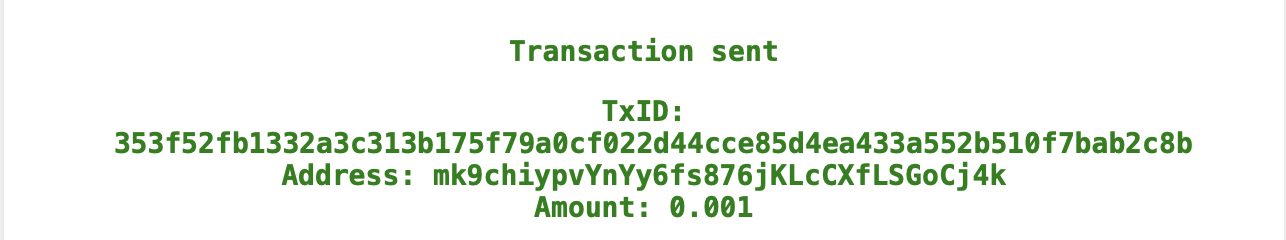


"Free Money!?", you ask? 

Not quite. Unforuntely, the bitcoins on testnet aren't worth anything.

Now, let's view our wallet address on testnet to ensure we did, in fact, receive the bitcoin. To do that I looked up "bitcoin testnet explorer", found blockstream.info/testnet, and entered our wallet address.

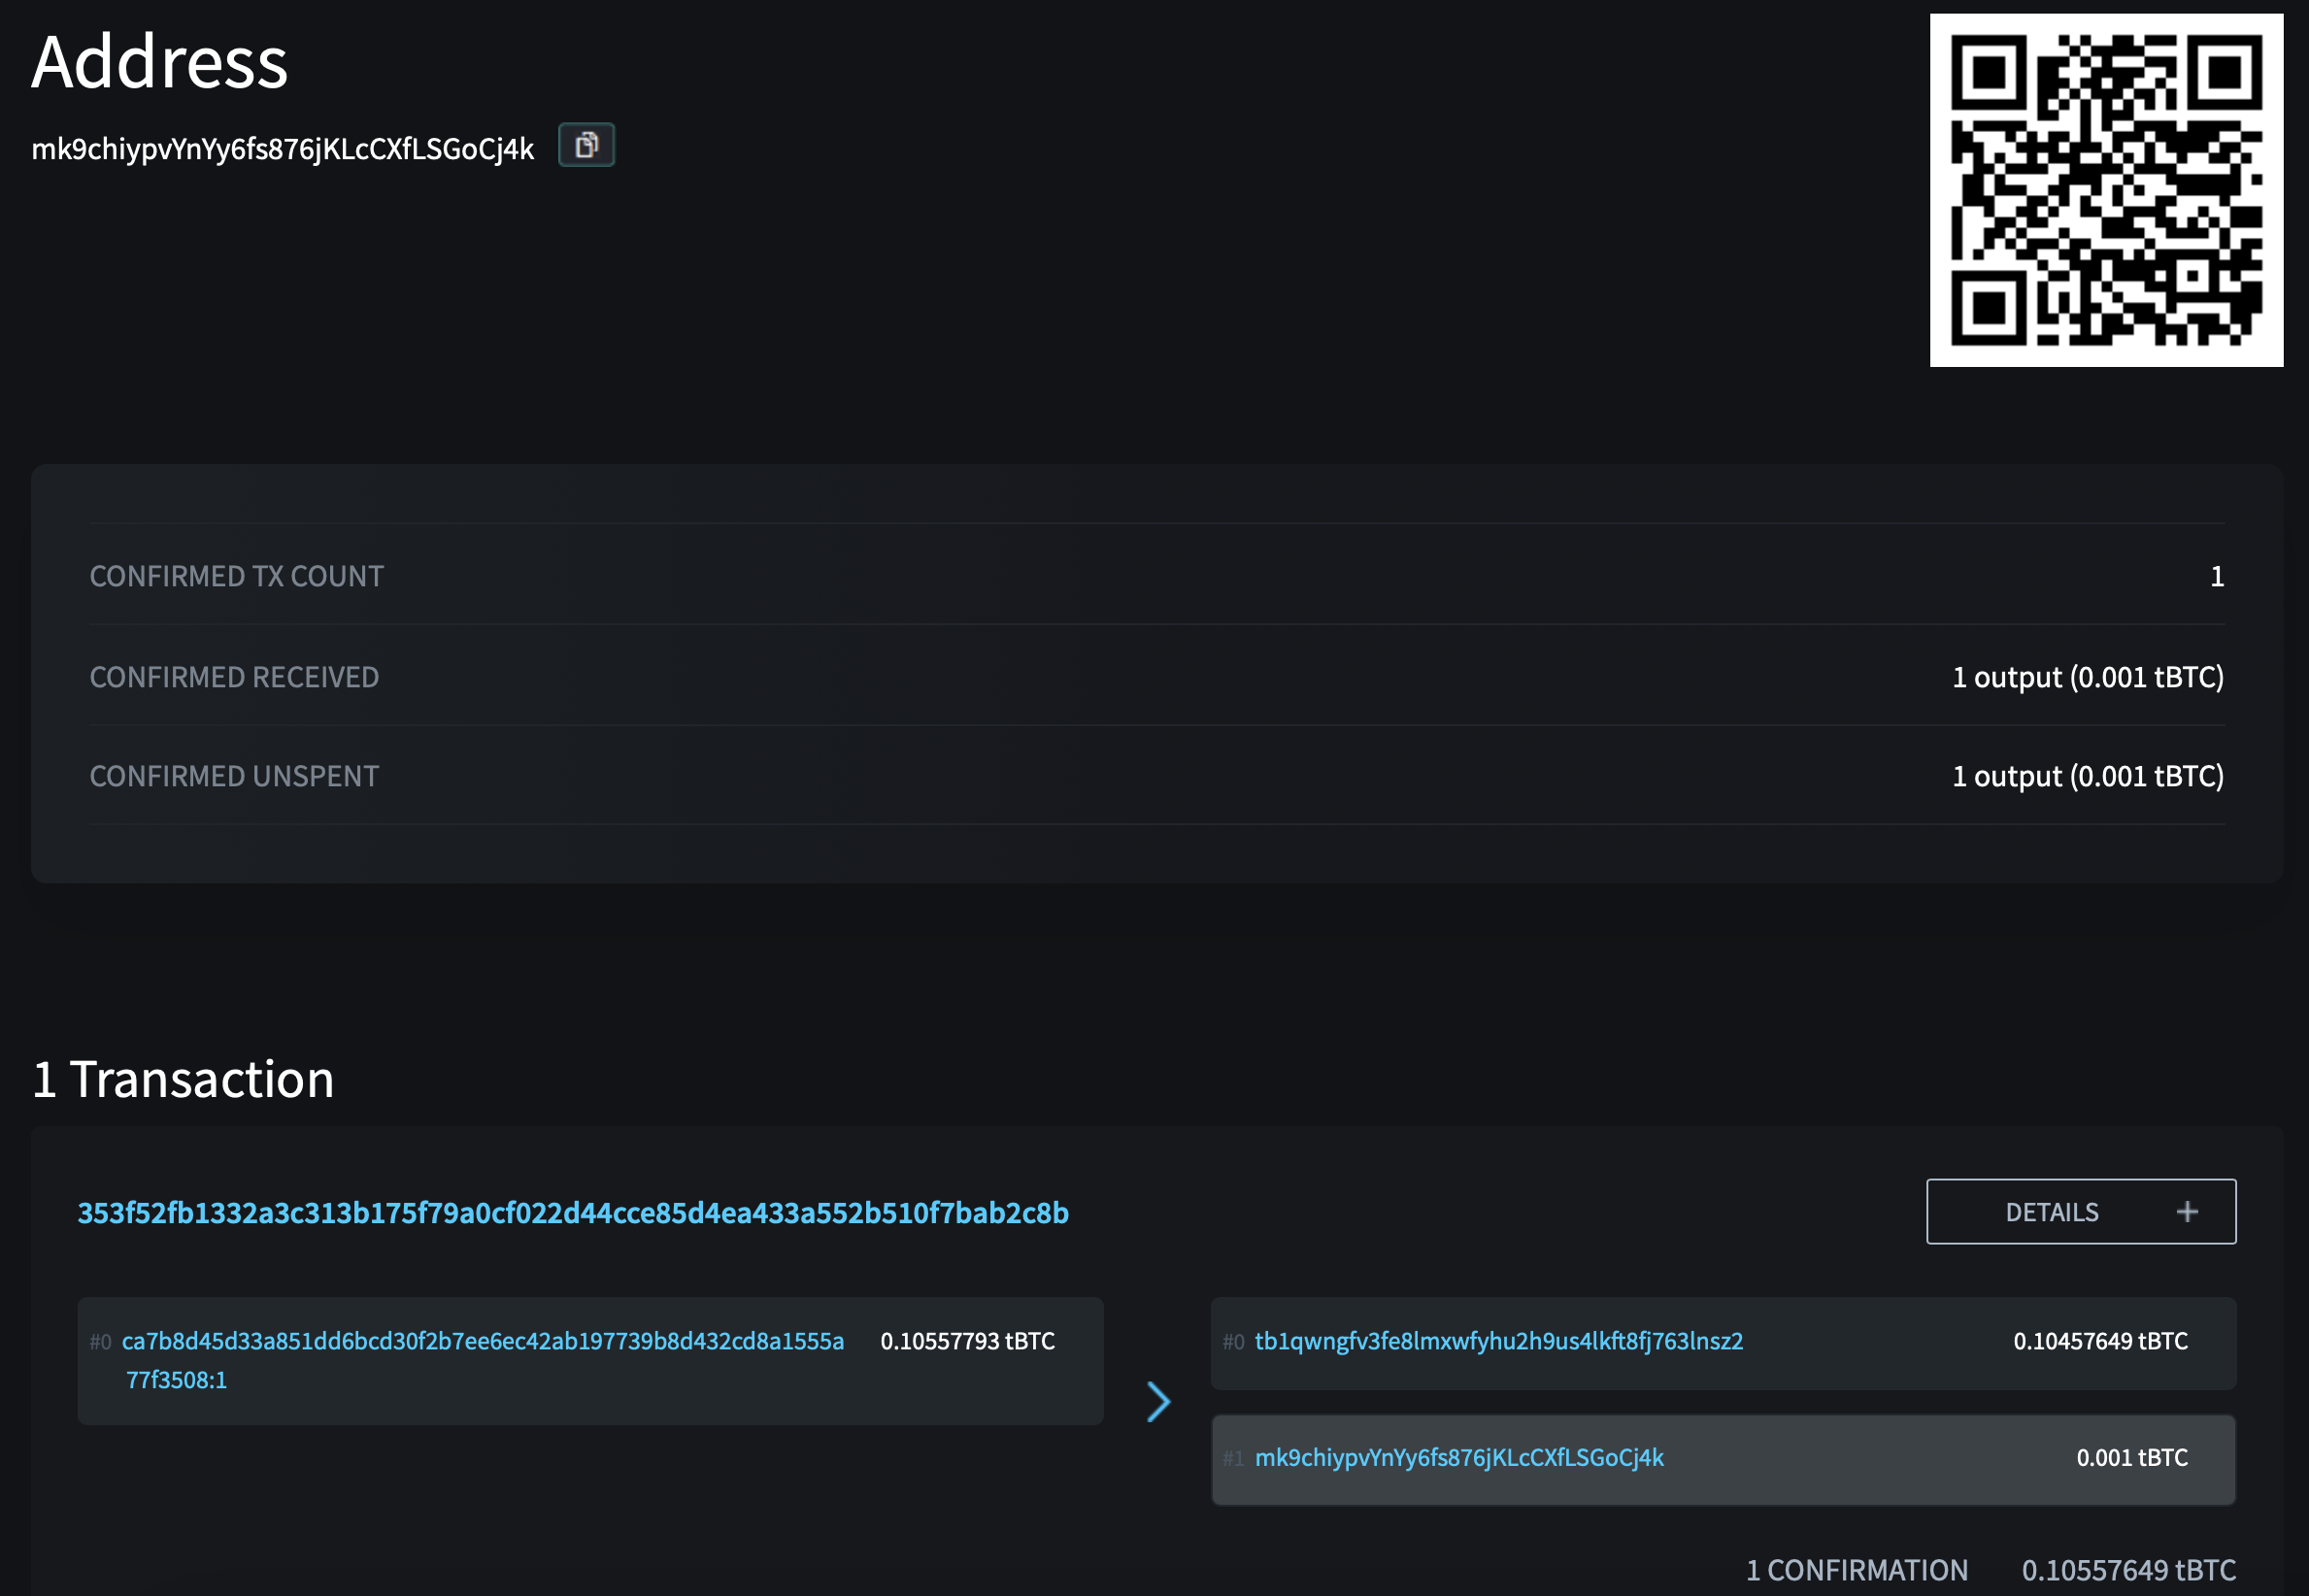


Okay there is a lot to unpack here.

So the first thing we notice is that our wallet does, in fact, exist. That's a great start! 

Next, we can see details about our wallet, including the total number of transactions, how much we've received, and how much remains unspent. On the bottom you can see our transaction id (353f52fb1332a3c313b175f79a0cf022d44cce85d4ea433a552b510f7bab2c8b), which should match up to one returned to us from the faucet.

As we will soon see, the transaction id is simply a hash256 of the encoded transaction, interpreted as little-endian.

If we click "Details" next to our Transaction ID, we get shown the below - which shows the inputs (left) and outputs (right) that our transaction was comprised of.

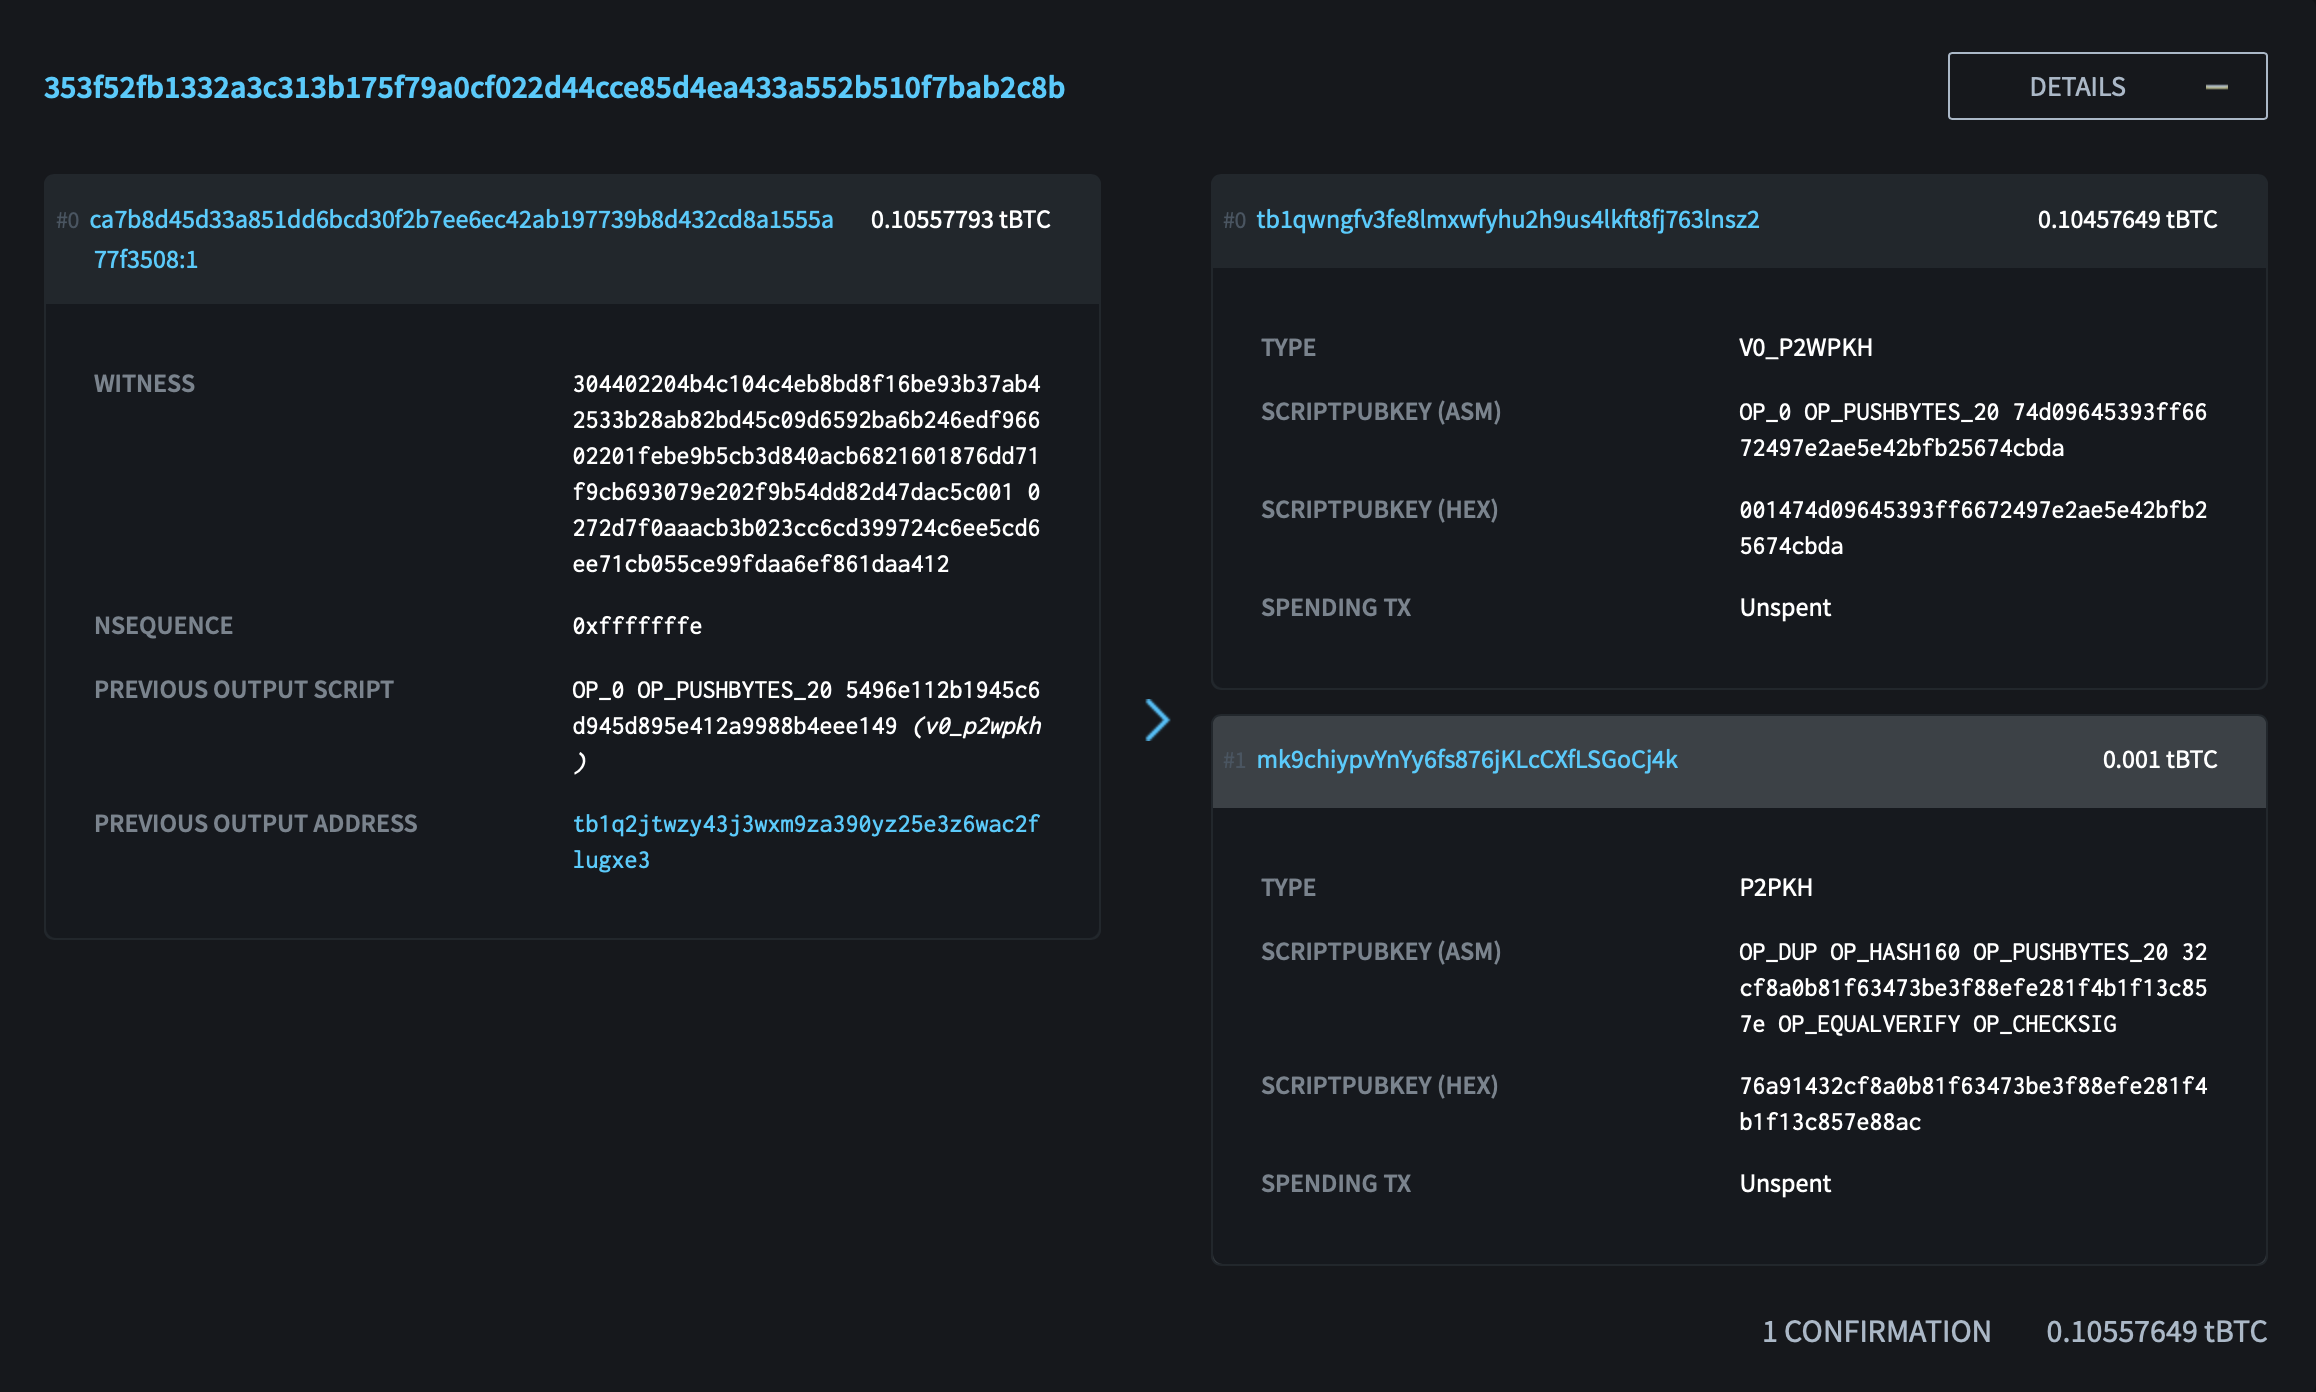



So you may be wondering why there is 1 input and 2 outputs. This is because a Bitcoin transaction works differently than how we conventionally think of transactions. 

In Bitcoin, each input actually points to the output of a previous transaction. This ensures you can't spend Bitcoin without receiving any first. 

This previous output needs to be unspent, and thus is called an Unspent Transaction Output--commonly referred to as a UTXO. The entire collective set of UTXO's at any given time is called the UTXO set and is important because it represents all available bitcoins currently in circulation.

What's key to understand here is that before the value can be split up, a UTXO must be fully spent. This is why in our screenshot above, the input has a much higher amount (0.10557793 BTC) than what was actually sent to us (0.001 BTC).

This is also why there are two outputs. The second output (with our wallet address) shows the amount that was sent (0.001 BTC). The first output (with the address of the sender) shows 0.10457649 BTC. The sender here, with an address of tb1qwngfv3fe8lmxwfyhu2h9us4lkft8fj763lnsz2, is from the testnet faucet we used to send ourselves bitcoin.

So, to reiterate, the input is the UTXO equaling 0.10557793 BTC. Because a UTXO must be fully spent, the entire amount is used to produce two outputs. In this case, the second output is the amount being sent, or 0.001 BTC. The first output is the "change" being sent back to the sender, or 0.10457649 BTC. Together the outputs total 0.10557649 BTC.

What might not be obvious here is that the inputs don't equal the outputs. This difference is called the "fee" and eventually goes to the Bitcoin miner who processes the block containing our transaction. Note here that a "block" is just a group/batch of transactions.

This whole process is like paying \\$20 for a \\$5 beer and receiving \\$12 back as change because we tipped the bartender \\$3. 

Continuing with this analogy, let's say you want a second round. The input to this new transaction will be the \\$12 you received back last time (this is the unspent output of your previous transaction - UTXO). The output will be another \\$5 to the bartender, and \\$4 back to you (because you again tipped \\$3). 

Before we code up the transaction, there are two more things we need to touch upon.

### Script

Bitcoin has an entire programming language for transactions, called Script. It is stack-based and consists of elements and operations. Script doesn't have most of the functionalities of modern-day programming languages (no loops, for example); however, the limited nature of it is what inherently makes it more secure. 

Every transaction creates a script that tells the next person wanting to spend the bitcoins how exactly to gain access to them. This script is referred to as the ScriptPubKey, or Public Key Script. ScriptPubKey essentially "locks" the bitcoins, while providing instructions of how to unlock them. To unlock them, there is another script called the Signature Script, or ScriptSig. We will be dealing with both of these very soon.

There are several types of transactions in Bitcoin, but the one we'll be focusing on is called pay-to-pubkey-hash, or P2PKH--which is commonly used when sending bitcoins from one wallet to another.

P2PKH uses the hash of the public key, rather than the public key itself. Aside from additional security, the advantage of hashing the public key is that it reduces it from 65 bytes (or 33 bytes compressed) to 20 bytes.

Anyway, the P2PKH ScriptPubKey ("locking" script) looks like this:

        OP_DUP OP_HASH160 <pkHash> OP_EQUALVERIFY OP_CHECKSIG
        
Note that each one of these commands beginning with "OP" is a specific operation. In plain english, this script is duplicating the public key, performing a hash160 on it, verifying the result is equal to the public key hash, and then finally checking the signature.
    
Once again, this is called the "locking" script, and provides instructions of how to unlock the bitcoins. To unlock the bitcoins (meaning to solve the P2PKH script), the owner of "pkhash" needs to provide the original public key and a valid signature for it. These two values are what makes up the ScriptSig.
    
        scriptPubKey: OP_DUP OP_HASH160 <pkHash> OP_EQUALVERIFY OP_CHECKSIG
    
        scriptSig: <sig> <pubKey>
    
As you will see, the ScriptPubKey is part of the transaction output, while the ScriptSig is part of the input. 
    
So, to recap, every input points to a previous output (UTXO). And because every UTXO contains a "locking" script (ScriptPubkey), every input will need to provide an "unlocking" script (ScriptSig) in order to access the bitcoins from the UTXO. If the bitcoins are successfully unlocked, they can then be spent. This is what is meant when people refer to "digital signatures" in Bitcoin.
    
Let's come back to our example. The below was the ScriptPubKey from the transaction sent to our Bitcoin wallet:
    
        OP_DUP OP_HASH160 OP_PUSHBYTES_20 32cf8a0b81f63473be3f88efe281f4b1f13c857e OP_EQUALVERIFY OP_CHECKSIG
    
All this says is the following: "In order to unlock the bitcoins, ScriptSig needs a public key that hashes to 32cf8a0b81f63473be3f88efe281f4b1f13c857e and a signature that was created by the secret key that generated this public key (recall how we created our public key earlier)." 
    
This brings us to digital signatures.
    
    

### Bitcoin Digital Signatures

The algorithm used for signatures in Bitcoin is called the Elliptic Curve Digital Signature Algorithm - or ECSDA. The signature is  generated from the private (secret) key. The signature itself is really a tuple (r, s). The math behind all this can be seen below.

    -----------------
    Let e = private key
    Let P = public key
    Let k = 256-bit random target
    Let R = (x, y) coords where r is x
    Let r = x coord of R
    Let z = signature hash
    -----------------
    u = z/s
    v = r/s

    eG = P

    kG = R = uG + vP
    vP = G(k - u)
    P = G((k-u)/v) = eG
    e = (k-u)/v
    k = u + ve = z/s + re/s = (z + re)/s
    s = (z + re)/k
    
Here is all that in english:

We are choosing a random 256-bit integer k which is between 0 and N (recall that N is a constant defined in secp256k1). To solve "r" we need to solve R = kG. Since G is known, and "k" is a random integer, this is cake.
Here, R is a point (x, y) along Bitcoin's elliptic curve, and "r" is the x-coordinate of this point.


Once we have "r", we can solve for "s" pretty easily to get our tuple (r, s) by using the following formula:

        s = (z + re)/k 
        
Note that "z" is the hash256 of an encoded transaction (the "message"), and "e" is our private/secret key, which is also known to us at this point.

So to solve "r" we pick a random integer and multiply it by Point G, and then take the x-coordinate of the result. Then, to solve "s", we multiply "r"  by the secret key, "e". We then take our encoded transaction, "z", add it, and finally divide the whole thing by our random "k". 

The randomness of k here is important as this is what protects your identity. This is why k is never revealed. In actuality, there is a deterministic process to generate k, detailed in RFC-6979, which can be read about here: https://datatracker.ietf.org/doc/html/rfc6979. 

This specification was designed to prevent any duplications of "k" across the Bitcoin network. There was a famous Playstion 3 hack that was caused by this exact risk (https://arstechnica.com/gaming/2010/12/ps3-hacked-through-poor-implementation-of-cryptography/). But I digress. 

In Bitcoin, the signature will be used to digitally sign a transaction. A signature proves that you know a private/secret key without actually revealing it. It allows you to access the bitcoins in the UTXO. 

As you will see, after signing a transaction, we are going to need to encode it using something called Distinguished Encoding Rules (DER) format. Note that s cannot be derived from r, so we cannot compress the signature.


Here is the code.

In [12]:
def rfc6979(sk: int, z: int) -> int:
    """
    Deterministic "k" generation for signatures
    """
    k = b"0x00" * 32
    v = b"0x01" * 32
    if z > N:
        z -= N
    z = z.to_bytes(32, "big")
    sk = sk.to_bytes(32, "big")
    for i in [b"\x00", b"\x01"]: #two rounds of sha256 (hash256) for added security 
        k = hmac.new(k, v + i + sk + z, hashlib.sha256).digest()
        v = hmac.new(k, v, hashlib.sha256).digest()

    while True:
        v = hmac.new(k, v, hashlib.sha256).digest()
        cand = int.from_bytes(v, "big")
        if 1 <= cand < N:
            return cand
        k = hmac.new(k, v+b"\x00", hashlib.sha256).digest()
        v = hmac.new(k, v, hashlib.sha256).digest()


class Signature(object):
    def __init__(self, r, s):
        self.r = r
        self.s = s
    
    def __repr__(self):
        return f"Signature(r:{self.r}\ns:{self.s})"
            
    @classmethod
    def from_private(cls, sk: int, z: int, randk: bool = False) -> Signature:
        """
        Generates a signature given a secret key and a "message"
        sk is the secret/private key
        z is the hash256 of an encoded Tx - hash256(tx.encode(sig_idx=0))
        """
        k = randsk() if randk else rfc6979(sk, z)
        r = (k*G).x #r is the x coord of R = kG
        s = modulardiv((z + r * sk), k, N)
        if s > N/2: #a low s will get nodes to relay transactions
            s = N - s
        return Signature(r, s)

    def encode(self) -> bytes:
        """
        Encode a Signature using DER Format
        """
        rbin = self.r.to_bytes(32, "big")
        rbin = rbin.lstrip(b"\x00") #remove null bytes 
        sbin = self.s.to_bytes(32, "big")
        sbin = sbin.lstrip(b"\x00")

        if rbin[0] >= 0x80:
            rbin = b"\x00" + rbin
        if sbin[0] >= 0x80:
            sbin = b"\x00" + sbin

        res = b"".join([bytes([0x02, len(rbin)]), rbin, bytes([0x02, len(sbin)]), sbin])
        return b"".join([bytes([0x30, len(res)]), res])
    
    


As you can see, DER format (used in Signature.encode) isn't anything crazy. Here are the steps:
    
    1. Start with 0x30 and the encode length of entire signature
    2. Encode both r and s as 32 bytes big endian integers 
    3. For both r and s, if the first byte is >= 0x80, prepend with 0x00
    4. Add [0x02, len(r), r, 0x02 len(s), s]
    
This might all be a bit confusing right now, so let's just throw it all together and see what happens.

## Bitcoin Transactions

Transaction inputs will contain the hashed contents of the previous transaction output, the index of the output we're trying to spend, and the ScriptSig ("unlocking" script). The output will contain the amount and the ScriptPubKey ("locking" script). It will look something like this:

        Input:
        Previous tx: f5d8ee39a430901c91a5917b9f2dc19d6d1a0e9cea205b009ca73dd04470b9a6
        Index: 0
        scriptSig: 304502206e21798a42fae0e854281abd38bacd1aeed3ee3738d9e1446618c4571d10
        90db022100e2ac980643b0b82c0e88ffdfec6b64e3e6ba35e7ba5fdd7d5d6cc8d25c6b241501

        Output:
        Value: 5000000000
        scriptPubKey: OP_DUP OP_HASH160 404371705fa9bd789a2fcd52d2c580b65d35549d OP_EQUALVERIFY OP_CHECKSIG
        
        
To start coding all this up, we will need a few helper functions to help us encode and decode integer values.

In [13]:
def encode_int(i: int, num_bytes: int, encoding: str = "little") -> bytes:
    """
    Encodes an integer into num bytes based on big or little endian
    """
    return i.to_bytes(num_bytes, encoding)

def decode_int(s: BytesIO, nbytes: int, encoding: str = "little") -> int:
    return int.from_bytes(s.read(nbytes), encoding)

def encode_varint(i: int) -> bytes:
    """
    Encode a very large integer into bytes with by compressing it with the following schema
    """
    if i < 0xfd: #253
        return bytes([i])
    elif i < 0x10000: #65536
        return b"\xfd" + encode_int(i, 2)
    elif i < 0x100000000: #4294967296
        return b"\xfe" + encode_int(i, 4) 
    elif i < 0x10000000000000000: #8446744073709551616
        return b"\xff" + encode_int(i, 8)
    else:
        raise ValueError("Integer is too large") 

def decode_varint(s: bytes) ->int:
    i = decode_int(s, 1)
    if i == 0xfd:
        return decode_int(s, 2)
    elif i == 0xfe:
        return decode_int(s, 4)
    elif i == 0xff:
        return decode_int(s, 8)
    else:
        return i

Variable Integers, or varints, are able to handle extremely large integers efficiently by compressing them with a simple algorithm. These are used in Bitcoin all over the place. The code for encoding/decoding varints is pretty self-explanatory, so to keep this post as short as possible, I will leave it at that.

Because we'll be dealing with Script, we'll also need an object to help us decode Script components.





In [14]:
def ensure_stream(b: Union[BytesIO, bytes]):
    assert type(b) in [bytes, BytesIO]
    if isinstance(b, bytes):
        return BytesIO(b)
    return b


class Script:
    def __init__(self, commands: List):
        self.commands = commands
    
    def __repr__(self):
        return f"Script({[x if isinstance(x, int) else x.hex() for x in self.commands]})"
    
    def __add__(self, other: Script):
        return self.__class__(other.commands + self.commands)
    
    @classmethod
    def decode(cls, b: bytes) -> Script:
        b = ensure_stream(b)
        l = decode_varint(b) #length
        if l == 0:
            return cls([])
        cmds = []
        i = 0
        #loop over bytes until l is reached, reading each byte at a time.
        while i < l:
            curr = int.from_bytes(b.read(1), "big")
            if 1 <= curr <= 75: #OP CODES 1-75 push data by their integer value (PUSH20 = 20 bytes)
                cmds.append(b.read(curr))
                i += curr
            elif curr == 76: #special case for elements larger than 75 bytes
                datalen = decode_int(s, 1, "little")
                cmds.append(b.read(datalen))
                i += datalen
            elif curr == 77: #another special case for large elements
                datalen = decode_int(s, 2, "little")
                cmds.append(b.read(datalen))
                i += datalen
            else: #is an op code
                cmds.append(curr)
            i += 1
        return cls(cmds)

    def encode(self) -> List[bytes]:
        out = []
        for cmd in self.commands:
            if isinstance(cmd, int):
                out += [encode_int(cmd, 1)] #OP_CODE -- encode as single byte
            elif isinstance(cmd, bytes):
                cmd_len = len(cmd)
                if cmd_len < 75:
                    out += [encode_int(cmd_len, 1)]
                elif 76 <= cmd_len <= 255:
                    out += [encode_int(76, 1), encode_int(cmd_len, 1)] #OP_PUSHDATA1
                elif 256 <= cmd_len <= 520:
                    out += [encode_int(77, 1), encode_int(cmd_len, 2)] #OP_PUSHDATA2
                else:
                    raise ValueError(f"Command Length ({cmd_len}) is too long. Must be <= 520")
                out += [cmd]
                
        ret = b"".join(out)
        return encode_varint(len(ret)) + ret #encode length as varint
        
        
def p2pkh_script(pkhash: bytes):
    """
    --------------
    Params
    --------------
        1. pkhash -> hash160 of public key (20 bytes)
    --------------
    Op Codes for P2PKH
    --------------
    118 - OP_DUP
    169 - OP_HASH160
    136 - OP_EQUALVERIFY
    172 - OP_CHECKSIG
    --------------
    Returns
    --------------
        1. -> P2PKH ScriptPubKey 
    --------------
    """
    assert len(pkhash) == 20, "Must be a hash160 resulting in 20 bytes"
    return Script([118, 169, pkhash, 136, 172])

There a few subtleties here, such as the one-off handling for OP_PUSHDATA1 and OP_PUSHDATA2. As you can see, the first byte is a varint describing the length of the script. We then loop until this length is reached, decoding bytes as we go along. At the start of each iteration, we are grabbing how long the field is (each field is preceded with its length as an integer), and then taking that many bytes. 

In Script, Op Codes are mapped to integer values. For example, OP_DUP has a value of 118, while OP_HASH160 has a value of 169. 

Op Codes 1-75 are for pushing elements into the stack and correspond to how many bytes need to be pushed. Codes 76 and 77 (OP_PUSHDATA1 and OP_PUSHDATA2) are for when the size of the element that needs to be pushed is larger than 75 bytes. A full list of Op Codes can be found here: https://wiki.bitcoinsv.io/index.php/Opcodes_used_in_Bitcoin_Script

The "encode" method for Script takes our commands list and serialize them.

As you can see above, we also defined a standard P2PKH Script Pubkey, as we will be utilizing this soon.

Lets now test all this out. We will first generate a random secret key between 1 and N, multiply it by G to calculate a public key, hash our public key, and finally create a ScriptPubKey (again, the "locking" script). 

In [15]:
sk = int.from_bytes(b"A really not secure secret key", "big")
assert 1 <= sk <= N
public_key = PublicKey.from_private(sk)
wallet = public_key.get_address(compressed=True)

print(f"Our Secret Key: {sk}\n\nOur Public Key: {public_key}\n\nOur Wallet Address: {wallet}\n\n")

script_pubkey = p2pkh_script(public_key.encode(compressed=True, hash_160=True))

print(f"ScriptPubKey: {script_pubkey}")

#double check our encode method

Script.decode(script_pubkey.encode()).commands == script_pubkey.commands

Our Secret Key: 449488278141529331570894587784025424259850355740764053729777188256572793

Our Public Key: PublicKey(curve=EllipticCurve(a=0, b=7) in Field(115792089237316195423570985008687907853269984665640564039457584007908834671663), x=114572056644531109437455668857360422178912603977719463965400697762196240248947, y=48684330654836836548704025270830624582210654401845932345315286755132145014255)

Our Wallet Address: mk9chiypvYnYy6fs876jKLcCXfLSGoCj4k


ScriptPubKey: Script([118, 169, '32cf8a0b81f63473be3f88efe281f4b1f13c857e', 136, 172])


True

Now, with all that out of the way, we are finally ready to build our transaction.

A standard Bitcoin transaction will have 4 components: Version, Inputs, Outputs, and Locktime.

We know what inputs and outputs are, but let's briefly touch upon version and locktime. Version is exactly what is sounds like--it describes what version a transaction is. For our purposes we will be using a version of 1, as that is the most general case.

Locktime was designed--along with "sequence" in our inputs--by Satoshi to enable high frequency trades. Both locktime and sequence were created to essentially compress a large batch of transactions between two parties into one single transaction. The locktime acts like a "time limit" and correlates to a block number. The sequence is how many transactions have occured prior to this time limit expiring (locktime) and increases incrementally with each successive transaction. However, there is a rule where if sequence is 0xffffffff, locktime is ignored.


The encode method of the transaction class creates the unhashed version of the "message" that we need to create our signature. This hashed version of this message is what we referred to as "z" in our calculations to obtain the (r, s) tuple that a signature consists of.


As stated before, a transaction output consists of the amount and the ScriptPubKey. Both the encode and decode methods here are pretty straightforward. During encode, the amount is encoded in 8 bytes little-endian and then--since the script_pubkey object is of our Script class we just built--we call the equivalent method of our Script class.

One thing to note here is that the amount is denoted in satoshis (SAT), which is 1/100,000,000th (1e-8) of a bitcoin (BTC).

Transaction inputs are encoded as follows: First, the bytes of the previous transaction are reversed to make it little-endian. Next, the previous index is encoded as 4 bytes little-endian. The script_sig will be of the Script class we built earlier, so we simply call its encode method. Finally, the sequence is encoded as a 4 byte integer. 

The decode method works in reverse. The first 32 bytes are the contents of the previous transaction, little-endian. The next 4 bytes are the index of the output, and also is little-endian. The script_sig is decoded and returned as a Script object. Lastly, the sequence is decoded back into an integer. 

You'll notice that our decode method can also handle Segwit, which stands for Segregated Witness. On this, I'll only being giving you the TLDR version:

This was a soft-fork upgrade in August 2017 that enabled larger block sizes and "transaction malleability", which is the ability to alter Transaction IDs without changing the meaning of the transaction itself. I chose to include it in Tx.decode because our testnet faucet transaction (which we'll want to retrieve) used segwit.

Anyway, a transaction can have many inputs and many outputs. That is why--as you can see in the encode method--the number of inputs and outputs have to be encoded via a varint before the actual inputs and outputs are subsequently encoded. 

Lastly, in the encode method, you will see something called a SIGHASH. This is just a byte denoting what part of the transaction we signed. For our purposes we will use SIGHASH_ALL, which is represented by "1".

It's time to use all of this to actually create a Bitcoin transaction.

In [16]:
class Tx(object):
    def __init__(self, 
                 version: int, 
                 inputs: List[dict], 
                 outputs: List[dict], 
                 locktime: int = 0):
        self.version = version
        self.inputs = inputs
        self.outputs = outputs
        self.locktime = locktime
        
    def __repr__(self):
        s = f"Version: {self.version}\nNum Inputs: {len(self.inputs)}\nInputs:\n"""
        for i in self.inputs:
            s += f'{i["prev_tx"].hex()} - {i["script_sig"]}\n'
            s += f'Index: {i["prev_idx"]}\n'
        s += f"Num Outputs: {len(self.outputs)}\nOutputs:\n"
        for o in self.outputs:
            s += f'{o["amount"]} SAT - {o["script_pubkey"]}\n'
        s += f'Locktime: {self.locktime}'
        return s
    
    def encode(self, sig_idx: int = -1):
        #version
        out = [encode_int(self.version, 4)] #4 byte little-endian
        
        #encode inputs
        out += [encode_varint(len(self.inputs))]
        out += [self.encode_inputs(sig_idx=sig_idx)]
        
        #encode outputs
        out += [encode_varint(len(self.outputs))]
        out += [self.encode_outputs()]
        
        #locktime and SIGHASH
        out += [encode_int(self.locktime, 4)]
        out += [encode_int(1, 4) if sig_idx != -1 else b""] #SIGHASH_ALL
        return b"".join(out)
    
    def encode_inputs(self, sig_idx: int = -1):
        """
        prev_tx is encoded to be little endian
        prev_idx, seq are 4 byte little endian encoded integers
        script_sig uses Script encoding
        """
        out = []
        for idx in range(len(self.inputs)):
            inp = self.inputs[idx]
            if sig_idx == -1 or sig_idx == idx:
                script_sig = inp["script_sig"].encode()  
            else:
                script_sig = Script([]).encode()
            out += [
                inp["prev_tx"][::-1], #reverse bytes
                encode_int(inp["prev_idx"], 4),
                script_sig,
                encode_int(inp["seq"], 4)
            ]
            
        return b"".join(out)

    def encode_outputs(self):
        out = []
        for o in self.outputs:
            encoded = [
                encode_int(o["amount"], 8),
                o["script_pubkey"].encode()
            ]
            out += encoded
        return b"".join(out)
    
    @classmethod
    def decode(cls, b: Union[bytes, BytesIO]) -> Tx:
        """
        Decodes the raw bytes of a transaction into a Tx object
        """
        b = ensure_stream(b)
        segwit, witness = False, []
        
        version = decode_int(b, 4)
        
        num_inputs = decode_varint(b)
        if num_inputs == 0:
            assert b.read(1) == b"\x01" #segwit marker -- need to read one more
            num_inputs = decode_varint(b)
            segwit = True
            
        inputs = []
        for n in range(num_inputs):
            prev_tx = b.read(32)[::-1] #little to big endian
            prev_idx = decode_int(b, 4)
            script_sig = Script.decode(b)
            seq = decode_int(b, 4)
            inputs.append({"prev_tx": prev_tx, 
                           "prev_idx": prev_idx, 
                           "script_sig": script_sig, 
                           "seq": seq})

        num_outputs = decode_varint(b)
        outputs = []
        for n in range(num_outputs):
            amt = decode_int(b, 8)
            script_pubkey = Script.decode(b)
            outputs.append({"amount": amt, 
                            "script_pubkey": script_pubkey})

        if segwit:
            for i in inputs:
                num_items = decode_varint(b)
                items = []
                for _ in range(num_items):
                    item_len = decode_varint(b)
                    if item_len == 0:
                        items.append(0)
                    else:
                        items.append(b.read(item_len))
                witness.append(items)

        locktime = decode_int(b, 4)
        return cls(version, inputs, outputs, locktime)
    

Now that we've built our transaction object (Tx), we have the ability to create transactions. To do this, we're going to want to grab some information about our previous faucet transaction. Of course, we could do this manually by typing our Transaction ID into the site we used before...but nah.

To help automate things a bit, we are going to quickly build a wrapper Blockstream's testnet API to extract data about transactions, and further broadcast transactions to the blockchain.

I'm not going to spend time explaining the code here, as it's a bit of an aside. To avoid excessively spamming the API (because we're not terrible people), we only call it when no cached data is availble.


In [17]:
import os
import requests
import json

class Network:
    """
    Wrapper for Blockstream's Testnet API
    """
    def __init__(self):
        self.cache_dir = "datacache/"
        if not os.path.isdir(self.cache_dir):
            os.makedirs(self.cache_dir, exist_ok=True)
        self.url = "https://blockstream.info/testnet/api/"
    
    def get_tx(self, txid: str, as_hex: bool = False) -> bytes:
        cachefile = self.cache_dir + "txdb"
        cachefile = os.path.join(cachefile, txid)
        txid = txid.lower()
        if os.path.isfile(cachefile):
            with open(cachefile, "rb") as f:
                raw = f.read()
        else:           
            url = self.url + f"tx/{txid}/hex"
            r = requests.get(url)
            assert r.ok, "Could not connect to API"
            raw = bytes.fromhex(r.text.strip())
            with open(cachefile, "wb") as f:
                f.write(raw)
        return raw if not as_hex else raw.hex()
    
    def get_tx_meta(self, txid: str):
        cachefile = self.cache_dir + "meta"
        cachefile = os.path.join(cachefile, txid) + ".json"
        txid = txid.lower()
        if os.path.isfile(cachefile):
            with open(cachefile, "r") as f:
                raw = json.loads(f.read())
        else:
            url = self.url + f"tx/{txid}"
            r = requests.get(url)
            assert r.ok, "Could not connect to API"
            raw = r.text.strip()
            with open(cachefile, "w") as f:
                f.write(str(raw))
        return raw
    
    def get_address(self, wallet: str) -> List:
        cachefile = self.cache_dir + "wallets"
        cachefile = os.path.join(cachefile, wallet) + ".json"
        url = self.url + f"address/{wallet}/txs"
        r = requests.get(url)
        assert r.ok, "Could not connect to API"
        raw = r.text.strip()
        with open(cachefile, "w") as f:
            f.write(str(raw))
        return json.loads(raw)

    def broadcast(self, tx: Union[bytes, str]):
        """
        Note tx must be hex of encoded signed transaction
        """
        if isinstance(tx, bytes):
            tx = tx.hex()
        url = self.url + "tx"
        r = requests.post(url, data=tx)
        assert r.ok, f"Bad POST: {r.status_code}"
        return r.text #return the txid
        
def get_tx_idx(wallet, prev_tx):
    pkhash = b58decode(wallet) #get the pkhash of the wallet
    for idx in range(len(prev_tx.outputs)):
        out = prev_tx.outputs[idx]
        out_pkhash = [x for x in out["script_pubkey"].commands if not type(x) is int]
        if out_pkhash:
            match = list(filter(lambda x: x, [x == pkhash for x in out_pkhash]))
            if match:
                return idx
    return None

net = Network()
tx_id = "353f52fb1332a3c313b175f79a0cf022d44cce85d4ea433a552b510f7bab2c8b"
oldtrans = net.get_tx(tx_id)
oldtrans.hex()

'0200000000010108357fa755158acd32d4b8397719ab42ece67e2b0fd3bcd61d853ad3458d7bca0100000000feffffff0231929f000000000016001474d09645393ff6672497e2ae5e42bfb25674cbdaa0860100000000001976a91432cf8a0b81f63473be3f88efe281f4b1f13c857e88ac0247304402204b4c104c4eb8bd8f16be93b37ab42533b28ab82bd45c09d6592ba6b246edf96602201febe9b5cb3d840acb6821601876dd71f9cb693079e202f9b54dd82d47dac5c001210272d7f0aaacb3b023cc6cd399724c6ee5cd6ee71cb055ce99fdaa6ef861daa41262a62000'

## Creating and Signing a Bitcoin Transaction

The entire goal of this section is to create and sign a Bitcoin transaction. To do that, we are going to spend our 0.001 BTC we received from the testnet faucet. For this, we are going to create a second address. We will be sending this address 1/4 of our bitcoin, or 0.00025 BTC (25,000 SAT). 

Our task here is to to populate the ScriptSig of the input we want to spend. In order to do that, we have to create the transaction, sign it, and then overwrite the input with this signature.

Let's first cover the creation of a transaction.

As stated already, each input in a transaction points back to the output of a previous transaction (UTXO). Because of this, we first use the UTXO's ScriptPubKey for the input's starting ScriptSig. 

If you think about it, this makes intuitive sense. Recall that a UTXO's ScriptPubkey is the "locking script". The entire point of the signing process is to generate a ScriptSig that satisfies the conditions of this ScriptPubkey and "unlock" the bitcoins. 

This whole process is basically saying "I am the owner of the unspent bitcoins in this previous transaction, and I can prove that with this Signature generated from my secret key" (without giving away your secret key, of course). 

Anyway, to do this, we need data about the previous transaction. To do this, we will use our API wrapper to get the most recent transaction from the sender's wallet. We then grab the transaction id. After, we do a second API call to get the encoded contents of that transaction. We use our newly-built Tx class to decode this.



In [18]:
secret_key = int.from_bytes(b"A really not secure secret key", "big")
assert 1 <= secret_key < N
public_key = PublicKey.from_private(secret_key)
wallet1 = public_key.get_address(compressed=True)

secret_key2 = int.from_bytes(b"bing bong!!", "big")
assert 1 <= secret_key2 < N
public_key2 = PublicKey.from_private(secret_key2)
wallet2 = public_key2.get_address(compressed=True)

print(f"Wallet 1 Address {wallet1}")
print(f"Wallet 2 Address {wallet2}")

net = Network()
sender_address = net.get_address(wallet1)
prev_tx_id = sender_address[0]["txid"] #api sorts the newest first
print("Prev Tx: ", prev_tx_id)
prev_tx = Tx.decode(net.get_tx(prev_tx_id)) 
prev_idx = get_tx_idx(wallet1, prev_tx)
assert prev_idx is not None
print(prev_idx)
print(f"UTXO Amount: {prev_tx.outputs[prev_idx]['amount']}")
prev_tx 

Wallet 1 Address mk9chiypvYnYy6fs876jKLcCXfLSGoCj4k
Wallet 2 Address mkK8GLp4ge625ZLpo3PeftAq3UprP3GDL5
Prev Tx:  353f52fb1332a3c313b175f79a0cf022d44cce85d4ea433a552b510f7bab2c8b
1
UTXO Amount: 100000


Version: 2
Num Inputs: 1
Inputs:
ca7b8d45d33a851dd6bcd30f2b7ee6ec42ab197739b8d432cd8a1555a77f3508 - Script([])
Index: 1
Num Outputs: 2
Outputs:
10457649 SAT - Script([0, '74d09645393ff6672497e2ae5e42bfb25674cbda'])
100000 SAT - Script([118, 169, '32cf8a0b81f63473be3f88efe281f4b1f13c857e', 136, 172])
Locktime: 2139746

Awesome, so far everything is looking good. You can see our 0.001 BTC (100,000 SAT) in the outputs. This is the bitcoin we will try to claim with our digital signature. 

You can also see our ScriptPubKey, which contains the hash160 of our public key in the middle of it.

    100000 SAT - Script([118, 169, '32cf8a0b81f63473be3f88efe281f4b1f13c857e', 136, 172])
    
Now that we have our two wallet addresses, and our sender's previous transaction, we can construct our transaction.

To do this we create two lists: inputs and outputs. Each element in both of these lists are dictionaries with all the data required to properly create a Bitcoin transaction. The code is below.

Notice how we specify our "change" amount to be less than the total UTXO. This is becuase we need to leave a "tip" for the miner (via the fee). So here, we are specifying a 5000 SAT fee.

Moreover, take note on how our output's ScriptPubKey is generated. If you recall, we create a wallet address by taking the hash160 of our public key, and encoding it using Base-58. Because of this, we only need to Base-58 decode our wallet address to retrieve the Public Key hash.

And lastly, remember that our input's initial ScriptSig ("initial" because we will soon be replacing this with our signature) is the ScriptPubkey of our UTXO it points to.


In [19]:
ins = [{
    "prev_tx": bytes.fromhex(prev_tx_id),
    "prev_idx": prev_idx,
    "script_sig": p2pkh_script(b58decode(wallet1)), #decode base58, wallet address hash pubkey hash in it
    "seq": 0xffffffff #not an important parameter, you can use this as default
}]

outs = [
    {"amount": 25000, "script_pubkey": p2pkh_script(b58decode(wallet2))}, #goes to target wallet
    {"amount": 70000, "script_pubkey": p2pkh_script(b58decode(wallet1))} #change that comes back to our wallet
       ]


tx = Tx(
    version = 1, #using 1 as verison 
    inputs = ins, 
    outputs = outs,
)

print(tx)
message = tx.encode(sig_idx = 0) #point to the input UTXO we are trying to spend
message.hex()

Version: 1
Num Inputs: 1
Inputs:
353f52fb1332a3c313b175f79a0cf022d44cce85d4ea433a552b510f7bab2c8b - Script([118, 169, '32cf8a0b81f63473be3f88efe281f4b1f13c857e', 136, 172])
Index: 1
Num Outputs: 2
Outputs:
25000 SAT - Script([118, 169, '349bf5d7b45c6366433d985a09735a26d2208539', 136, 172])
70000 SAT - Script([118, 169, '32cf8a0b81f63473be3f88efe281f4b1f13c857e', 136, 172])
Locktime: 0


'01000000018b2cab7b0f512b553a43ead485ce4cd422f00c9af775b113c3a33213fb523f35010000001976a91432cf8a0b81f63473be3f88efe281f4b1f13c857e88acffffffff02a8610000000000001976a914349bf5d7b45c6366433d985a09735a26d220853988ac70110100000000001976a91432cf8a0b81f63473be3f88efe281f4b1f13c857e88ac0000000001000000'

Once we define our transaction, we then want to sign it to prove to the entire network that our sender is indeed the owner of the UTXO we are trying to spend. To do this, we want to create the "message", which again is denoted "z" when we calculate our signature. The message is just the encoded version of the transaction, pointing to the specific input UTXO we want to spend (in our case there is only 1 input, so we just use index 0). 

Now that we have our message created, we want to hash it and create our (r, s) signature tuple. 

We then encode the signature using DER Format, and tack on a SIGHASH_ALL marker (denoted by the number 1). This signature is then combined with the encoded (not hashed!) version of the public key to create our ScriptSig.

Finally, once we have our ScriptSig, we want to overwrite the input with it.

In [20]:
sig = Signature.from_private(secret_key, z=int.from_bytes(hash256(message), "big"))
sig = sig.encode() + b"\x01" 
pubkey_bytes = PublicKey.from_point(public_key).encode(compressed=True, hash_160=False)
script_sig = Script([sig, pubkey_bytes])
tx.inputs[0]["script_sig"] = script_sig #sign our input
print(tx)
print(f"Transaction Size: {len(tx.encode())} bytes")
tx.encode().hex()

Version: 1
Num Inputs: 1
Inputs:
353f52fb1332a3c313b175f79a0cf022d44cce85d4ea433a552b510f7bab2c8b - Script(['3044022036599108a992c27a2fcca6f28309b3e6e4d17de9f575f0052e107edc69bdff23022023c9eccd0cf44271ed3b20f84b5db1df109b43edbe3807ca6d5294adba35670b01', '03fd4d7c6c072c9ae5e96139fcf99c36aac902c18a0d99948bc2cb54fd08f8b073'])
Index: 1
Num Outputs: 2
Outputs:
25000 SAT - Script([118, 169, '349bf5d7b45c6366433d985a09735a26d2208539', 136, 172])
70000 SAT - Script([118, 169, '32cf8a0b81f63473be3f88efe281f4b1f13c857e', 136, 172])
Locktime: 0
Transaction Size: 225 bytes


'01000000018b2cab7b0f512b553a43ead485ce4cd422f00c9af775b113c3a33213fb523f35010000006a473044022036599108a992c27a2fcca6f28309b3e6e4d17de9f575f0052e107edc69bdff23022023c9eccd0cf44271ed3b20f84b5db1df109b43edbe3807ca6d5294adba35670b012103fd4d7c6c072c9ae5e96139fcf99c36aac902c18a0d99948bc2cb54fd08f8b073ffffffff02a8610000000000001976a914349bf5d7b45c6366433d985a09735a26d220853988ac70110100000000001976a91432cf8a0b81f63473be3f88efe281f4b1f13c857e88ac00000000'

And that's it! 

We have just created our very first Bitcoin transaction. Pretty neat, huh?

To broadcast a transaction, we encode the entire thing (which will be 225 bytes in our case), and take the hexadecimal value. This hex will contain the contents of our entire signed transaction. The transaction id is calculated by taking the little-endian interpretation of the hash256 of the encoded contents.

Using our API wrapper, let's now broadcast this transaction out to the blockchain. Note that the API will return the transaction id if all goes smoothly. 

In [21]:
txid = net.broadcast(tx.encode().hex())
print(f"Transaction ID : {txid}")
hash256(tx.encode())[::-1].hex() == txid

Transaction ID : aaf1a4fa390bdbfcf543a0ace7b93e406d78667ca32568edcb01e7598e3828d4


True

## Transaction Verification

Now that our transaction has been sucessfully broadcasted, it needs to be validated.

Miners validate transactions in order to obtain the fee and the block reward (to be discussed next).

The process of validating a transaction is somewhat straightforward. There are really only a few things that need to be checked:

        1. The inputs are unspent - meaning they're in the UTXO set. This prevents double-spending.
        2. The sum of the inputs is ≥ the sum of the outputs. This ensures no new bitcoins are created.
        3. The ScriptSig unlocks the ScriptPubKey
        
        
To code this up, we will need a couple things. First, we will need to decode our signature (DER Format) and public key (SEC Format). Remember, these two values are what make up the ScriptSig. To do that, we'll need a helper function to perform a modular square root, as when the public key is compressed, we will need to solve for y in Bitcoin's elliptic curve equation y^2 = x^3 + 7.



In [22]:
def modularsqrt(x, p):
    """
    Modular Square Root of (x) with prime (p)
    """
    return pow(x, (p+1)//4, p)

def decode_pubkey(b: bytes):
    """
    Decode SEC formatted binary PublicKey
    - reversing the PublicKey.encode() method here
    """
    assert isinstance(b, bytes)
    curve = G.curve
    if b[0] == 4: #uncompressed -- straightforward
        x = int.from_bytes(b[1:33], 'big')
        y = int.from_bytes(b[33:65], 'big')
        return Point(curve, x, y)
    if b[0] in [2, 3]: #compressed -- need to solve for y in y^2 = x^3 + 7
        even = b[0] == 2
        x = int.from_bytes(b[1:], 'big')
        y2 = (x**3 + 7) % P #y^2 == x^3 + 7
        y = modularsqrt(y2, P) #modular square root
        y_even = y % 2 == 0
        if even != y_even: #ensure both have same "evenness"
            y = P - y
        return Point(curve, x, y)
    raise ValueError("Bytes must be encoded in SEC Format")
        
def decode_sig(sig_bytes: bytes):
    """
    Decodes DER Formatted binary Signature
    - just reverseing Signature.encode() method here
    - dont forget about the sighash b"\x01" we added!
    """
    b = ensure_stream(sig_bytes)
    assert b.read(1)[0] == 0x30
    length = b.read(1)[0]
    assert length == len(sig_bytes) - 3 # -3 excludes the starting 0x30, length, sighash
    assert b.read(1)[0] == 0x02
    rlength = b.read(1)[0]
    r = int.from_bytes(b.read(rlength), 'big')
    assert b.read(1)[0] == 0x02
    slength = b.read(1)[0]
    s = int.from_bytes(b.read(slength), 'big')
    assert len(sig_bytes) == 7 + rlength + slength # 7 is metadata + sighash
    return Signature(r, s)

def validate_signature(pt: Point, 
                       message: bytes, 
                       sig: Signature) -> bool:
    """
    Validates a signature given public key (p), message (z) and signature
    Same math we used to generate our signature is used here
    u = z/s
    v = r/s
    R = uG + vp
    r = R.x
    assert r == sig.r
    """
    assert 1 <= sig.r <= N
    assert 1 <= sig.s <= N
    z = int.from_bytes(hash256(message), 'big') #the hash256 of the message (which is tx.encode(sig_idx))
    u = modulardiv(z, 
                   sig.s, N) #u = z/s
    v = modulardiv(sig.r, 
                   sig.s, N) #v = r/s
    r = ((u * G) + (v * pt)).x
    return r == sig.r

def validate_tx(utxo: Tx, 
                tx: Tx, 
                message: bytes,
                public_key: PublicKey) -> bool:
    """
    -----------
    Verify a p2pkh Transaction
    -----------
    """
    prev_idx = tx.inputs[0]["prev_idx"] #index of the UTXO spent
    script_sig = tx.inputs[0]["script_sig"].commands #ScriptSig -> <der_sig> <sec_pubkey>
    script_pubkey = utxo.outputs[prev_idx]["script_pubkey"].commands #"locking" script of UTXO
    input_amt = utxo.outputs[prev_idx]["amount"] #UTXO amount
    
    output_amt = sum([out["amount"] for out in tx.outputs])
    if output_amt > input_amt: #ensure no new bitcoins are created
        return False

    pkhash = public_key.encode(compressed=True, hash_160=True) #hash of the sender's public key
    #remember we are using p2pkh, so our pkhash is the third element
    if pkhash != script_pubkey[2]: #==OP_EQUALVERIFY
        return False

    sig, pk = decode_sig(script_sig[0]), decode_pubkey(script_sig[1]) 
    if not validate_signature(pt=pk, 
                              message=message, 
                              sig=sig): #==OP_CHECKSIG
        return False
    
    #note that we need to look at the UTXO set to verify this output hasn't been spent -- skip that for brevity
    return True

print("Tx is valid: ", validate_tx(prev_tx, tx, message, public_key))


Tx is valid:  True


Now that we have the ability to create, broadcast, and verify Bitcoin transactions, we are ready for what I call the "buzzword part of Bitcoin". This includes all the things you've heard about--blocks, blockchain, mining, nodes, and of course, Proof-of-Work.



## Blocks and the Blockchain

As stated before, blocks are just batches of transactions. These transactions settle roughly every 10 minutes, based on Block difficulty (which will be discussed).

##### Coinbase Transactions
The first transaction in a block is called the Coinbase Transaction (which has absolutely nothing to do with the company of the same name). What's special about a coinbase transaction is that it's the only transaction capable of producing new bitcoins. These bitcoins are called the "block reward", and go to whoever mines the block.  

The block reward is halved every 210,000 blocks (about every 4 years) in an event called "the halving". When Bitcoin was first implemented, the block reward was 50 blocks. As of writing, the block reward is 6.25 Bitcoins, which is currently worth over $250,000! 

"The halving" was designed by Satoshi to limit inflation. In fact, there is even a cap on the number of bitcoins that can ever be created--which is 21,000,000 BTC. This is what gives Bitcoin its scarce property. 

At its current pace, the block reward is scheduled to hit zero around 2140. However, over 90% of bitcoins have already been "mined". This means that over time, miners will have to rely more and more on fees for profitability, rather than the block reward.

Anyway, back to Coinbase Transactions. These are pretty much the same as normal transactions, with a few key exceptions:

    - They must have only one input.
    - The input must have a previous transaction of 32 bytes of 00.
    - The input must have a previous index of ffffffff.
    - The ScriptSig is set by whoever mined the transaction (must be between 2 and 100 bytes)
    
Because the ScriptSig is set by the miner, there were initially some issues that were fixed in a soft-fork called BIP0034, which implemented "height" to the block. Height is essentially the block number. More specifically, it is a little-endian integer and represents the number of blocks since the Genesis Block.

The Genesis Block is the very first block to exist in Bitcoin. It was mined by Satoshi himself and even contained a readable message in the ScriptSig, which can be seen in the code below:


In [23]:
genesis_script_sig = '4d04ffff001d0104455468652054696d65732030332f4a616e2f32303039204368616e63656c6c6f72206f6e206272696e6b206f66207365636f6e64206261696c6f757420666f722062616e6b73'
Script.decode(bytes.fromhex(genesis_script_sig)).commands[2]


b'The Times 03/Jan/2009 Chancellor on brink of second bailout for banks'

Kind of ominous, I know. What I've realized--which I'll get into later--is that it's the little things like this that make Bitcoin as interesting as it is. 

One thing this message proves is that the Genesis Block was created on or after January 3rd, 2009. Futhermore, although no one actually knows who Satoshi Nakamoto is (or was), many point to this message as proof he/she was from the UK.

What's interesting about the Genesis Block is that it was hard-coded into bitcoin's source code. This is because there is no previous block that the Genesis Block points to. The block reward was sent to wallet address 1A1zP1eP5QGefi2DMPTfTL5SLmv7DivfNa--but actually cannot be spent due to a quirk in the source code whereby the transaction isn't in the global transactional database. No one knows if this "quirk" was intentional or simply a bug in the code. Laslty, many believe this address to be owned by Satoshi, however like many things in Bitcoin, this is also unknown.

You can read more about the Genesis Block here: https://en.bitcoin.it/wiki/Genesis_block

Anyway, let's get back to some code. As you'll see, a block acts pretty similar code-wise to a transaction.

There are 6 main things we need to construct a block.

    1. Version:
        - The version is simply which version of Bitcoin was used
    2. Previous Block ID
        - This is the block id. Like a transaction the id is the hash256 of the encoded block contents, little-endian. 
        - Every block points to a previous block, hence why they call it a "blockchain". 
    3. Merkle Root:
        - This is a single hash of all the block's transactions hashes (so a hash of hashes).
    4. Timestamp:
        - Unix timestamp
        - Used for calculating new bits/target/difficulty every 2,016 (technically 2015, as we'll see) blocks
    5. bits
        - Encodes the proof of work necessary in this block
    6. nonce
        - stands for "number used only once"
        - Miners use this (and change it) to solve proof-of-work
        
The encode method is similar to a transactions. First the version is encoded as a 4 byte intetger. Then both the previous block and the merkle root are encoded as 32 bytes little endian. Both bits and nonce are 4 bytes total. Adding all these up gives us 80 bytes.

The encoded block is what is referred to as a Block Header. 

In [24]:
class Block(object):
    """
    --------
    PARAMS
    --------
    1. version - which version of Bitcoin
    2. prev_block - the block id (hash256 little-endian) of previous block
                    Every block points to its previous block. This is why its called blockchain. 
    3. merkle_root - encodes all the ordered transactions in a 32-byte hash (see https://en.bitcoinwiki.org/wiki/Merkle_tree)
    4. timestamp - Unix timestamps are the number of seconds since January 1, 1970
                   used for calculating a new bits/target/difficulty every 2,016 blocks
    5. bits - encodes the proof-of-work necessary in this block
    6. nonce - “number used only once,” or n-once. This is what is changed by miners when looking for proof-of-work.

    """
    def __init__(self, version, prev_block, merkle_root, timestamp, bits, nonce, tx_hashes=None):
        self.version = version
        self.prev_block = prev_block
        self.merkle_root = merkle_root
        self.timestamp = timestamp
        self.bits = bits
        self.nonce = nonce
        self.tx_hashes = tx_hashes
    
    def __repr__(self):
        s = f"""
        Block(
            version: {self.version}
            prev_block: {self.prev_block.hex()}
            merkle_root: {self.merkle_root.hex()}
            timestamp: {self.timestamp}
            bits: {self.bits.hex()}
            nonce: {self.nonce.hex()}
            Difficulty: {self.difficulty()}
        )
        """
        return s

    def encode(self) -> bytes:
        """
        Returns the block header (80 bytes)
        """
        out = [encode_int(self.version, 4)] #4 bytes little endian
        out += [self.prev_block[::-1]] #32 bytes little endian
        out += [self.merkle_root[::-1]] #32 bytes little endian
        out += [encode_int(self.timestamp, 4)] #4 bytes little endian
        out += [self.bits, self.nonce] #4 bytes, 4 bytes
        return b"".join(out)

    @classmethod
    def decode(cls, b: Union[BytesIO, bytes]) -> Block:
        b = ensure_stream(b)
        version = decode_int(b, 4)
        prev_block = b.read(32)[::-1] #little to big endian
        root = b.read(32)[::-1]
        timestamp = decode_int(b, 4)
        bits = b.read(4)
        nonce = b.read(4)
        return cls(version, prev_block, root, timestamp, bits, nonce)
    
    def to_target(self):
        """
        Takes the bits and generates a number  (256 bits)
        Note this is compared to a target number for Proof of Work
        """
        exp = self.bits[-1] #last byte is the exponents
        coef = decode_int(BytesIO(self.bits[:-1]), 3) #first three are the coefficient
        return coef * 256**(exp - 3)
    
    def get_id(self):
        return hash256(self.encode())[::-1].hex()
    
    def difficulty(self) -> int:
        """
        Uses bits to calculate block difficulty
        Formula:
         (target of lowest difficulty) / (self's target)
        """
        lowest = 0xffff * 256**(0x1d - 3)
        return int(lowest / self.to_target())
    
    

For demonstration purposes, let's test this on Bitcoin's Genesis Block.

In [25]:
#Genesis Block for Bitcoin mainnet and testnet
GENESIS = {
    'main': bytes.fromhex('0100000000000000000000000000000000000000000000000000000000000000000000003ba3edfd7a7b12b27ac72c3e67768f617fc81bc3888a51323a9fb8aa4b1e5e4a29ab5f49ffff001d1dac2b7c'),
    'test': bytes.fromhex('0100000000000000000000000000000000000000000000000000000000000000000000003ba3edfd7a7b12b27ac72c3e67768f617fc81bc3888a51323a9fb8aa4b1e5e4adae5494dffff001d1aa4ae18'),
}

Block.decode(GENESIS["test"])



        Block(
            version: 1
            prev_block: 0000000000000000000000000000000000000000000000000000000000000000
            merkle_root: 4a5e1e4baab89f3a32518a88c31bc87f618f76673e2cc77ab2127b7afdeda33b
            timestamp: 1296688602
            bits: ffff001d
            nonce: 1aa4ae18
            Difficulty: 1
        )
        

And this brings us to maybe the biggest buzzword in all of crypto: Proof-of-Work.

## Proof-of-Work, Mining, and Block Difficulty

At face value, Proof-of-Work (PoW) is actually a simple concept: produce a number below a target number. 

To produce this number, miners use the block header (which, again, is just the encoded block). Specifically, they use the bits field--which is actually two numbers (a coefficient and an exponent). To produce the target number, a simple calculation is done: coef * 256**(exp-3). So the target is a 256-bit number.

A valid Proof-of-Work is the hash of the block header that produces a little-endian integer that is below the target number. And producing this valid Proof-of-Work is what people mean when they say "mining". 

This target number is extremely hard to produce. In fact, to do so the entire bitcoin network must calculate 3.8 × 10^21 hashes! Apparently (according to a quick web search), the best GPU card in the world would take around 50,000 years to perform that many calculations. 

The "hardness" sorrounding solving PoW is referred to as Block Difficulty. It is a standard calculation used to help quantify how hard it is to find that target number.
        
        - (0xffff * 256**(0x1d - 3)) / target
For context, the difficulty of the Genesis Block was 1.

Every 2,016 blocks is what's referred to as a Difficulty Adjustment Period. At the end of this period, blocks either become harder or easier to mine. However, becuase of how the targets are calculated, the time to create a block will always average out to around 10 minutes. This means that if half the computing power suddenly left the Bitcoin network, the block creation time will still regress towards 10 minutes. 

    >>> time_differential = (2016th block's timestamp) – (1st block' timestamp)
    >>> new_target = previous_target * time_differential / (2 weeks)
    
What's pretty funny about this whole "every 2016 blocks" thing is that Satoshi actually had an error in his code, whereby 2015 blocks are used instead. Fixing this bug would require a hard-fork--and we all know how much die-hard bitcoiner's love the idea of hard-forks. Alas, the bug still remains. 

So let's sum all of this up. Proof-of-Work is a calculated number that is very hard to find. Miners attempt to hit this target number by using the block header. Because the sha256 hashing algorithm produces a uniform distribution, the block header hash is a randomized number. And because the target is a relatively small number, the odds of finding one of these hashes in a random process is miniscule. In fact, on average PoW requires about 10^22 bits to be processed. 

To reach this target number, miners alter the nonce field in the block header--which when hashed via sha256, produces a new number to compare to the target. To reset the nonce field, miners can change the coinbase transaction, which ultimately changes the Merkle Root (which we'll discuss in a second) and clears nonce. 

In fact, this nonce field has to be reset often. Take, for example, the Bitcoin AntMiner S9 (which costs a few hundred bucks)--which can calculate 12 terahashes per second! That computing power would take 0.0003 seconds to clear the nonce field. 


So Proof-of-Work is just a gigantic, iterative, brute-force guessing process. 

    1. Use bits of the block header to calculate our number, and say a prayer it's below the target
    2. It's definitely not 
    3. Change the nonce field to produce a new block header hash, and go back to step 1
    
If you go back to blockstream.info/testnet and type in the transaction, you will see the ID of the block it was included in. We can grab this ID, use the API to return the block header hexadecimal, and decode it using our newly created Block object. Let's do this now:

In [26]:
#block id (hash256 of block.encode()) for the block that our transaction was apart of
block_id = "0000000000000078bf9dd673997fdcdd3534af881a6157ec6e6e4e24ba789e45"

#use blockstream's testnet API to get the block header to decode
url = f"https://blockstream.info/testnet/api/block/{block_id}/header"
r = requests.get(url)

block = Block.decode(bytes.fromhex(r.text))
assert block.get_id() == block_id
block

#verify Proof-of-Work
#assert int.from_bytes(hash256(block.encode()), "little") < target



        Block(
            version: 547356672
            prev_block: 00000000000000743e49b3225ffd42d52596ae5dad3bfbf4795f360d78c1a5f2
            merkle_root: 5e34b461770ef7ea619e799efd77d0704d219d6bdcefc6a8c76471ab54b5a7c0
            timestamp: 1644176836
            bits: 63ac001a
            nonce: 28496580
            Difficulty: 24914342
        )
        

Let's now utilize the API to retrieve the hashes of all transactions in this block. As you can probably guess, the hashes represent all transactions in this block. They are just the hash256 of encoded transactions, which again is how the transaction ID is constructed.

In [27]:
#get the tx_hashes for this block -- these show what transactions are in this block
url = f"https://blockstream.info/testnet/api/block/{block_id}/txids"
r = requests.get(url)
hashes = json.loads(r.text)
block.tx_hashes = hashes


In [28]:
block.tx_hashes

['5f9919bc99300f2044bcf598349721cbdd38d193f125dee1ef0d11cc97a37f9c',
 'ae75b6aeee0d9a4bb61513501156ae0d4fcc7332eb5df5571cbecc2ec7d39a11',
 'd5af62ac37c2b8bc751a330f5663e27fa4d04a2cc21f235e5e62731fffe25c2c',
 'a7dbf945a4faa2ed4310ab8c12fe307d3b4e71a0c63e52af955d6e2340b1a43b',
 '35f70e4989db093b537adb15e5fa1d9fd2e79c79c6faa94e521af5fdf3c83588',
 '48ec729785266344d6b057749f1d073c2dd046d4c34363332c358a5ef793c3a5',
 'e25ed01adc6bf06abbeae9b6bb66e7b3e4d7b1abbb75aed99d287f8de6128b1a',
 '8fa08e7012b550db2f31bdabec949770e441a0f44bb33df4f7d3746c64482e22',
 '6c3bf9e0b082090f40304b627f2e6cd8f08337cb7cca5aac9f3862c72f82e2d0',
 'dcfa9133ee0d76f4a7a0732b7ce1295884b6abd45b7d42a6a0d7d7fbea9d1009',
 '261a087fd4115f5cad8659be79f30edb222849fa97f780e66eb1a3bd06aa214a',
 'a5ac0ab7769f178249c6e3090e6340811d648b23a9ff7b719a3386c323de1fb3',
 '1ad7d64b0d10b41fd3de148e864bc1e1fe6c8498deafc41d7e76cd5ed997c960',
 '488a395a62ce30e0111894eca014c7c385a08a97647887175b2ba28a4d409686',
 '48a176a0722f35a276db11bc97aa525a

## Proof-of-Inclusion and Merkle Roots 


So what is this merkle root parameter anyway?

Well, for starters, a Merkle Tree is a way to structure data. The Merkle Root is the result of constructing such a structure, and for our purposes is just a 32 byte hash of transaction hashes (the TX ID). The hashes are referred to as leaves, and the entire structure is the Tree. Given a list of hashes [A B C D], it is constructed like this:
    
    [A B C D] -> [hash(A,B), hash(C, D)] -> if more than 1 hash in our list, repeat process
    
So given a list of hashes, a merkle tree is constructed using the following iterative process:

    1. Take all transactions, and hash each one
    2. If there is an odd number of hashes, we duplicate the last one 
    3. Pair up the hashes into groups of 2
    4. Hash these pairs
    5. Loop from step 3 until there is only a single hash left (the merkle root)
    
So the Merkle Root is the single hash that results from this process. And because the merkle root is a hash of all combined transactions within a block, it is said to provide "proof of inclusion". What this means is that it's proving a specific transaction is in a certain block (~ efficiently ~). 

With that, let's briefly touch on Bitcoin nodes. A node is a computer that runs Bitcoin software and stores the entire blockchain. Nodes relay block information to other computers on the Bitcoin network in order to keep the blockchain up-to-date. A way they do this is by using a command called "merkleblock", which transmits transaction data via a Merkle Tree. 

The contents of the merkleblock command is exactly the same as the block header, with an additional 4 fields appended to it. These 4 fields make up "proof of inclusion":

    1. Number of Transactions -- how many leaves the merkle tree has (4 bytes)
    2. Number of Hashes -- (varint)
    3. Hashes -- All the hashes (32 bytes * num hashes)
    4. Flag bits -- Gives info about where the hashes go within the merkle tree

Reference: https://en.wikipedia.org/wiki/Merkle_tree

Below, we will use our block's transaction hashes to naively construct the Merkle Tree. Remember: the Merkle Root is the final product of this construction process.

In [29]:
def get_merkle_parent(hashes: List[Union[str, bytes]], as_hex: bool = True) -> List:
    """
    Pair up all the hashes, concatenate them, and take a hash256 
    """
    parent = []
    for i in range(0, len(hashes)-1, 2):
        h1, h2 = hashes[i], hashes[i+1]
        if isinstance(h1, str):
            h1, h2 = bytes.fromhex(h1), bytes.fromhex(h2)
        new_hash = hash256(h1 + h2)
        if as_hex:
            new_hash = new_hash.hex()
        parent.append(new_hash)
    return parent
    
    
#ensure even number of hashesh
if len(block.tx_hashes) % 2 != 0:
    block.tx_hashes.append(block.tx_hashes[-1])

merkle_tree = [block.tx_hashes] #bottom of merkle tree will all the hashes
assert len(merkle_tree) > 0

#loop until we reach a single hash
while True:
    curr_level = merkle_tree[-1]
    if len(curr_level) == 1: #merkle root has been reached
        break
    merkle_tree.append(get_merkle_parent(curr_level))




In [30]:
for level in reversed(merkle_tree):
    s = " <-- Merkle Root" if len(level) == 1 else ""
    ex = [f"{x[:4]}..." for x in level]
    print(str(ex) + s)


['3897...'] <-- Merkle Root
['f59d...', '8adb...']
['0370...', 'd583...', '4147...', 'a74f...']
['d530...', '247b...', '4fca...', '6c45...', 'ed17...', 'c07b...', 'dd67...', 'f420...']
['ad0f...', '6ba5...', '7df2...', '480b...', '126e...', '5030...', '3ab4...', 'b02d...', '1c3d...', 'dffb...', '6202...', '04e8...', '6994...', '357c...', 'deb8...', '0847...', '2dd6...']
['5f99...', 'ae75...', 'd5af...', 'a7db...', '35f7...', '48ec...', 'e25e...', '8fa0...', '6c3b...', 'dcfa...', '261a...', 'a5ac...', '1ad7...', '488a...', '48a1...', 'a2c3...', 'e474...', 'c00d...', '5f41...', '3cf1...', '384c...', '4d31...', '3c6d...', '24ea...', 'f3eb...', 'efbe...', 'ae56...', '5a2f...', 'c897...', 'c3b2...', '8601...', 'c4c5...', '220d...', '220d...']


Awesome. With that, we have everything we need to define an object to represent a MerkleTree. Note that for brevity, we won't be getting into how to traverse this tree; however, the below should at least show you the general concept of how the Merkle Root is found.

In [31]:
class MerkleTree(object):
    def __init__(self, tree: List):
        self.tree = tree
        self.root = tree[0][::-1] #convert to little endian
    
    def __repr__(self):
        return f"MerkleTree(root={self.root})"
    
    @classmethod
    def construct(cls, hashes: List[str]):
        """
        Constructs a Merkle Tree from a list of hashes
        """
        hashes = [bytes.fromhex(h)[::-1] for h in hashes] #little to big-endian
        #ensure even number of hashesh
        if len(hashes) % 2 != 0:
            hashes.append(hashes[-1])
            
        merkle_tree = [hashes] #bottom of merkle tree will all the hashes
        
        assert len(merkle_tree) > 0

        #loop until we reach a single hash
        while True:
            curr_level = merkle_tree[-1]
            if len(curr_level) == 1:
                break
            merkle_tree.append(get_merkle_parent(curr_level))
            
        return cls(list(reversed(merkle_tree)))
        
MerkleTree.construct(block.tx_hashes)

MerkleTree(root=['ba2959ce1206c38acc833e47e1f688fe7d8e9f953da2bba50cac137abe739d57'])

## Summary

So to recap, Bitcoin operates within a finite field with prime P, and exists along an elliptic curve y^2 = x^3 + 7. The parameters of Bitcoin's elliptic curve are defined in secp256k1. One of these parameters, G, is the Generator and is the point from which public keys (and further, wallets) are created. 

To construct a Bitcoin transaction, we need a previous unspent output (UTXO) of our sender's wallet. The ScriptPubKey of this UTXO locks the bitcoin and provides instructions of how to unlock it. Once we have this, we encode the transaction to create a "message", which we then sign with our ECDSA signature. We encode this in DER format, and combine it with our SEC encoded public key to create a ScriptSig (our "unlocking" script). After we use this ScriptSig to overwrite the input, we encode the entire transaction, convert it to a hexadecimal, and broadcast it.

These transactions are then included in a block, which is just an ordered batch of transactions. The hashed transactions are also included in the block, and are used to construct the merkle root (which is needed for Proof-of-Inclusion).

Miners then want to verify these transactions and process the block to obtain the block reward via the coinbase transaction. To do so, they need to provide sufficient Proof-of-Work, which means using the block header (aka the encoded block) to produce a number below a target. And because of the nature of the sha256 hashing algorithm, this is extremely hard to do. 

Because this is so hard, Bitcoin automatically adjusts the mining difficulty every 2,016 (but actually 2,015) blocks in a way such that the time to settle transactions will always regress towards 10 minutes.

## Some Concluding Thoughts

Perhaps the most interesting thing about Bitcoin isn't the code itself, but rather the "lore" around it. And the fact that Satoshi Nakamoto has managed to remain faceless since Bitcoin's inception has no doubt fueled this lore. 

I believe this to be both good and bad for Bitcoin - the reasons for which stem from the same fact. Bitcoin is obviously the original cryptocurrency, and has developed a massive following. This is good in the sense that it gives Bitcoin a higher chance of widespread adoption, as it is a "fan-favorite" so to speak. However, it might also play out to be detrimental, as strong feelings in the Bitcoin community have caused a lot of strife over the years. 

It isn't a stretch to say that some parts of the Bitcoin community have become fanatical. And while this passion has definitely helped Bitcoin remain the largest cryptocurrency, it has also impeded progress. 

Take, for example, the SegWit upgrade that happened in 2017. When this occurred, many in the Bitcoin community were outraged and responded by hard-forking Bitcoin to create another crypto called Bitcoin Cash - taking a significant amount of computing power out of Bitcoin.

While there are two sides to every coin, the fact is many Bitcoin proponents have historically fought against key upgrades. Perhaps this is why, despite Bitcoin being the oldest cryptocurrency, it is still one the most energy inefficient.

All that being said, I find Bitcoin - and the crypto space in general - to be fascinating. There is no doubt that the software behind Bitcoin (some of which we coded today) will revolutionize many different industries in the coming years. 

Just take a look at NFTs, for example. The rapid rise of these "non-fungible tokens" is a testament to the power of the decentralized technology that is core to what Bitcoin is. 

And to think that this world-changing technology was created by someone/something that has managed to remain anonymous this whole time…

Anyway, if you'd like to learn more about all of this, I recommend any of the below resources.

If you'd like to learn more about all of this, I recommend any of the below:

    1. https://www.amazon.com/Programming-Bitcoin-Learn-Program-Scratch/dp/1492031496
    2. http://karpathy.github.io/2021/06/21/blockchain/
    3. https://en.bitcoin.it/wiki/Main_Page 
    
 